<a href="https://colab.research.google.com/github/AnaadKaur/Forest-Fire-Detection/blob/main/Forest%20Fire%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

## Run the two cells below for output wrap-around

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"lineWrapping": True}}})

{'CodeCell': {'cm_config': {'lineWrapping': True}}}

## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import altair as alt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pprint import pprint
import geemap
import matplotlib.pyplot as plt

## Authentication and Initialization

In [ ]:
import ee
ee.Authenticate()

In [ ]:
ee.Initialize(project='ee-anaad')

## Asset handling

In [ ]:
#===============================================================================
# Move all assets from src_folder to dest_folder
#===============================================================================

def move_assets(src_folder, dest_folder):
    assets = ee.data.listAssets({'parent': src_folder})
    for asset in assets['assets']:
        reg = asset['id'].split('/')[-1]
        new_asset = dest_folder + '/' + asset['id'].split('/')[-1]
        ee.data.copyAsset(asset['id'], new_asset, True)
    # uncomment if you want to delete source asset
        # ee.data.deleteAsset(asset['id'])


#===============================================================================
# Delete all assets from src_folder
#===============================================================================

def delete_assets(src_folder):
    assets = ee.data.listAssets({'parent': src_folder})
    for asset in assets['assets']:
        ee.data.deleteAsset(asset['id'])

In [ ]:
#===============================================================================
# Export a collection to drive or as asset
#===============================================================================

def export_to_drive(collection, output_filename):
    task = ee.batch.Export.table.toDrive(
      collection = collection,
      description = output_filename,
      fileFormat = 'csv',
    #   selectors = ['ID', 'date', 'area', 'geometry'],
      folder='anaad',
    )
    task.start()

def export_to_asset(collection, output_assetid, output_filename):
    export_task = ee.batch.Export.table.toAsset(
        collection = collection,
        description = output_filename,
        assetId = output_assetid,
    )
    export_task.start()

# Load district, block and microwatershed boundaries

In [ ]:
district_boundaries = ee.FeatureCollection('projects/ee-anaad/assets/India_district_boundaries')
aez_boundaries = ee.FeatureCollection('projects/ee-anaad/assets/India_AEZ_boundaries')
block_boundaries = ee.FeatureCollection('projects/ee-anaad/assets/AEZ_mapped_block_boundaries')

In [ ]:
blocks_odisha = ee.FeatureCollection('projects/ee-anaad/assets/District_blocks/Odisha')
blocks_jharkhand = ee.FeatureCollection('projects/ee-anaad/assets/District_blocks/Jharkhand')
blocks_rajasthan = ee.FeatureCollection('projects/ee-anaad/assets/District_blocks/Rajasthan')
blocks_bihar = ee.FeatureCollection('projects/ee-anaad/assets/District_blocks/Bihar')

In [ ]:
mws_angul = ee.FeatureCollection('projects/ee-anaad/assets/Microwatershed_boundaries/angul')
mws_masalia = ee.FeatureCollection('projects/ee-anaad/assets/Microwatershed_boundaries/masalia')
mws_pindwara = ee.FeatureCollection('projects/ee-anaad/assets/Microwatershed_boundaries/pindwara')
mws_mandalgarh = ee.FeatureCollection('projects/ee-anaad/assets/Microwatershed_boundaries/mandalgarh')
mws_mohanpur = ee.FeatureCollection('projects/ee-anaad/assets/Microwatershed_boundaries/mohanpur')

In [ ]:
aoi_angul = ee.FeatureCollection('projects/ee-anaad/assets/Block_boundaries/angul')
aoi_masalia = ee.FeatureCollection('projects/ee-anaad/assets/Block_boundaries/masalia')
aoi_pindwara = ee.FeatureCollection('projects/ee-anaad/assets/Block_boundaries/pindwara')
aoi_mandalgarh = ee.FeatureCollection('projects/ee-anaad/assets/Block_boundaries/mandalgarh')
aoi_mohanpur = ee.FeatureCollection('projects/ee-anaad/assets/Block_boundaries/mohanpur')

In [ ]:
roi_angul = None
roi_dumka = district_boundaries.filter(ee.Filter.eq('Name', 'Dumka'))
roi_sirohi = district_boundaries.filter(ee.Filter.eq('Name', 'Sirohi'))
roi_bhilwara = district_boundaries.filter(ee.Filter.eq('Name', 'Bhilwara'))
roi_gaya = district_boundaries.filter(ee.Filter.eq('Name', 'Gaya'))

In [ ]:
block_names = {
     "angul",
    "masalia",
    "pindwara",
    "mandalgarh",
    "mohanpur"
}
district_from_block = {
    "angul": "angul",
    "masalia": "dumka",
    "pindwara": "sirohi",
    "mandalgarh": "bhilwara",
    "mohanpur": "gaya"
}

In [ ]:
#===============================================================================
# Set *aoi*, *roi*, and *mws* from *block_name*
#===============================================================================

def set_block(block_name):
    if block_name=='angul':
        aoi = aoi_angul
        roi = roi_angul
        mws = mws_angul

    if block_name=='masalia':
        aoi = aoi_masalia
        roi = roi_dumka
        mws = mws_masalia

    if block_name=='pindwara':
        aoi = aoi_pindwara
        roi = roi_sirohi
        mws = mws_pindwara

    if block_name=='mandalgarh':
        aoi = aoi_mandalgarh
        roi = roi_bhilwara
        mws = mws_mandalgarh

    if block_name=='mohanpur':
        aoi = aoi_mohanpur
        roi = roi_gaya
        mws = mws_mohanpur

    return aoi, roi, mws

# Helper functions

In [ ]:
#===============================================================================
# Set ID of fire_regions using uids of intersecting microwatersheds
#===============================================================================

def set_properties(fire_regions, mws):
    idList = ee.List.sequence(0,fire_regions.size().subtract(1))
    fire_regions_list = fire_regions.toList(fire_regions.size())

    def set_prop_helper(newSysIndex):
        feature = ee.Feature(fire_regions_list.get(newSysIndex))
        intersecting_mws = mws.filterBounds(feature.geometry())
        uidList = intersecting_mws.aggregate_array('uid').add(ee.Number(newSysIndex).toInt())
        uid = uidList.join('_')
        return feature.set('system:index', uid, 'ID', uid)#, 'geometry', feature.geometry())

    return ee.FeatureCollection(idList.map(set_prop_helper))

#===============================================================================
# Function to compute statistics for fire_regions
#===============================================================================

def compute_stats(fire_regions):
    num_fires = fire_regions.size().getInfo()
    min_area = fire_regions.aggregate_min('area').getInfo()
    max_area = fire_regions.aggregate_max('area').getInfo()
    mean_area = fire_regions.aggregate_mean('area').getInfo()
    total_area = fire_regions.aggregate_sum('area').getInfo()
    return num_fires, min_area, max_area, mean_area, total_area

In [ ]:
#===============================================================================
# Function to get composite image with MODIS and VIIRS bands from landsat-8 image
#===============================================================================

def getNativeImage(image_lsat):
    path = image_lsat.get('system:index').getInfo()
    # projection = image_lsat.select('B7').projection().getInfo()

    image_mod09ga_id = "MODIS/061/MOD09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]
    try:
        ee.data.getAsset(image_mod09ga_id)
    except ee.EEException:
        print("MODIS/061/MOD09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:], 'does not exist.')
        return None

    image_vnp09ga_id = "NOAA/VIIRS/001/VNP09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]
    try:
        ee.data.getAsset(image_vnp09ga_id)
    except ee.EEException:
        print("NOAA/VIIRS/001/VNP09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:], 'does not exist.')
        return None

    image_mod09ga = ee.Image(image_mod09ga_id).select(['sur_refl_b01','sur_refl_b02','sur_refl_b03','sur_refl_b04','sur_refl_b05','sur_refl_b06','sur_refl_b07'])#.reproject(crs = projection['crs'], crsTransform = projection['transform'])
    image_mod09ga = image_mod09ga.clip(image_lsat.select('B7').geometry())#.updateMask(image_lsat.select('B7').mask())
    image_vnp09ga = ee.Image(image_vnp09ga_id).select(['I1','I2','I3','M1','M2','M3','M4','M5','M7','M8','M10','M11'])#.reproject(crs = projection['crs'], crsTransform = projection['transform'])
    image_vnp09ga = image_vnp09ga.clip(image_lsat.select('B7').geometry())#.updateMask(image_lsat.select('B7').mask())
    # image_mod11a1 = ee.Image("MODIS/061/MOD11A1/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:])
    # image_mod11a1 = image_mod11a1.select(['LST_Day_1km', 'LST_Night_1km', 'Emis_31', 'Emis_32']).reproject(crs = projection['crs'], crsTransform = projection['transform'])
    # image_mod11a1 = image_mod11a1.updateMask(manual_annotation_patch.mask()).clip(manual_annotation_patch.geometry())

    image = image_lsat.addBands(image_mod09ga).addBands(image_vnp09ga)
    return image


def getReprojectedImage(image_lsat):
    path = image_lsat.get('system:index').getInfo()
    projection = image_lsat.select('B7').projection().getInfo()

    image_mod09ga_id = "MODIS/061/MOD09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]
    try:
        ee.data.getAsset(image_mod09ga_id)
    except ee.EEException:
        print("MODIS/061/MOD09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:], 'does not exist.')
        return None

    image_vnp09ga_id = "NOAA/VIIRS/001/VNP09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]
    try:
        ee.data.getAsset(image_vnp09ga_id)
    except ee.EEException:
        print("NOAA/VIIRS/001/VNP09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:], 'does not exist.')
        return None

    image_mod09ga = ee.Image(image_mod09ga_id).select(['sur_refl_b01','sur_refl_b02','sur_refl_b03','sur_refl_b04','sur_refl_b05','sur_refl_b06','sur_refl_b07']).reproject(crs = projection['crs'], crsTransform = projection['transform'])
    image_mod09ga = image_mod09ga.clip(image_lsat.select('B7').geometry())#.updateMask(image_lsat.select('B7').mask())
    image_vnp09ga = ee.Image(image_vnp09ga_id).select(['I1','I2','I3','M1','M2','M3','M4','M5','M7','M8','M10','M11']).reproject(crs = projection['crs'], crsTransform = projection['transform'])
    image_vnp09ga = image_vnp09ga.clip(image_lsat.select('B7').geometry())#.updateMask(image_lsat.select('B7').mask())
    # image_mod11a1 = ee.Image("MODIS/061/MOD11A1/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:])
    # image_mod11a1 = image_mod11a1.select(['LST_Day_1km', 'LST_Night_1km', 'Emis_31', 'Emis_32']).reproject(crs = projection['crs'], crsTransform = projection['transform'])
    # image_mod11a1 = image_mod11a1.updateMask(manual_annotation_patch.mask()).clip(manual_annotation_patch.geometry())

    image = image_lsat.addBands(image_mod09ga).addBands(image_vnp09ga)
    return image

In [ ]:
#===============================================================================
# Function to map blocks to the AEZ they lie in, can be easily adapted for ACZ boundaries
#===============================================================================

def mapBlocksToAEZs(block):
    block = ee.Feature(block)
    intersections = aez_boundaries.map(lambda aez: aez.set('area', block.intersection(aez).area()))
    max_area = intersections.aggregate_max('area')
    max_aez_id = intersections.filter(ee.Filter.eq('area', max_area)).first().get('ae_regcode')
    return block.set('aez_id', max_aez_id)

# Uncomment the following lines to map and export blocks
# mapped_blocks = block_boundaries.map(mapBlocksToAEZs)
# export_to_asset(mapped_blocks, 'projects/ee-anaad/assets/AEZ_mapped_block_boundaries', 'AEZ_mapped_block_boundaries')

# Sets of conditions to classify pixels as fire or non-fire

### [Schroeder](https://www.sciencedirect.com/science/article/pii/S0034425715301206)

In [ ]:
#===============================================================================
# EQUATIONS (Schroeder)
#===============================================================================
# The following functions implement the equations in the paper:https://www.sciencedirect.com/science/article/pii/S0034425715301206.

def Seq1(image, r75, diff75):
    '''identifies potentially unambiguous active fire pixels
    builds on the ETM + active fire algorithm while accommodating small differences in OLI spectral channels'''
    return r75.gt(2.5).And(diff75.gt(0.3)).And(image.select('B7').gt(0.5))

#-------------------------------------------------------------------------------

def Seq2(image):
    '''highly energetic and extensive fires can lead to folding of the DN on channel 7
    thereby characterizing another condition of potentially unambiguous active fire pixels'''
    return image.select('B6').gt(0.8).And(image.select('B1').lt(0.2)).And(image.select('B5').gt(0.4).Or(image.select('B7').lt(0.1)))

#-------------------------------------------------------------------------------

def Seq3(r75, diff75):
    '''complementing the identification of unambiguous fire pixels, the thresholds in test (1) are relaxed
    and other candidate fire pixels are selected for further analyses'''
    return r75.gt(1.8).And(diff75.gt(0.17))

#-------------------------------------------------------------------------------

def Seq4and5(b7, r75, unamb_fires, water):
    '''all pixels satisfying test (3) must then meet the following set of fixed threshold and contextual tests
    in order to be classified as potential fire-affected pixels'''

    # means and standard deviations are computed ignoring pixels showing channel 7 reflectance <= zero, unambiguous fires, as well as water pixels.
    ignored_pixels = b7.lte(0).Or(unamb_fires.Or(water))
    kept_pixels = ignored_pixels.Not()
    r75 = r75.updateMask(kept_pixels)
    b7 = b7.updateMask(kept_pixels)

    reducers = ee.Reducer.mean().unweighted().combine(reducer2=ee.Reducer.stdDev().unweighted(),sharedInputs=True)
    stats_r75 = r75.reduceNeighborhood(reducers, ee.Kernel.square(30, 'pixels', False))
    stats_b7 = b7.reduceNeighborhood(reducers, ee.Kernel.square(30, 'pixels', False))

    potential_r75 = r75.gt(stats_r75.select('R75_mean').add(stats_r75.expression("(3*b('R75_stdDev') > 0.8) ? 3*b('R75_stdDev') : 0.8")))
    potential_b7 = b7.gt(stats_b7.select('B7_mean').add(stats_b7.expression("(3*b('B7_stdDev') > 0.08) ? 3*b('B7_stdDev') : 0.08")))
    return (potential_r75.And(potential_b7)).unmask(unamb_fires)

#-------------------------------------------------------------------------------

def Seq6(image):
    '''additional test for potential fires'''
    return (image.select('B7').divide(image.select('B6'))).gt(1.6)

#-------------------------------------------------------------------------------

def Seq7to9(image):
    '''water pixels are classified based on spectral profiling using reflectance data from all seven input channels
    two distinct tests are applied in order to map oceans and inland water bodies'''
    return image.select('B4').gt(image.select('B5'))\
    .And(image.select('B5').gt(image.select('B6')))\
    .And(image.select('B6').gt(image.select('B7')))\
    .And((image.select('B1').subtract(image.select('B7'))).lt(0.2))\
    .And(image.select('B3').gt(image.select('B2'))
        .Or(image.select('B1').gt(image.select('B2'))
            .And(image.select('B2').gt(image.select('B3')))
            .And(image.select('B3').gt(image.select('B4')))
        )
    )

#-------------------------------------------------------------------------------

def getFireMaskSchroeder(image):

    r75 = image.select('B7').divide(image.select('B5')) # Compute only once (used by multiple equations).
    r75 = r75.select(['B7'], ['R75'])
    diff75 = image.select('B7').subtract(image.select('B5')) # Compute only once (used by multiple equations).
    diff75 = diff75.rename(['D75'])

    # Unambiguous fires (satisfy eq 1 or 2).
    unamb_fires = Seq1(image, r75, diff75).Or(Seq2(image))

    # Potential fires (satisfy eq 3).
    potential_fires = Seq3(r75, diff75)

    # Test eq 6 before eq 4 and 5 in an attempt to avoid the time-consuming contextual test when possible.
    potential_fires = potential_fires.And(Seq6(image))

    # Water pixels (used by the contextual test and excluded from the result.
    water = Seq7to9(image)

    # Contextual test for potential fires (eq 4 and 5).
    potential_fires = potential_fires.And(Seq4and5(image.select('B7'), r75, unamb_fires, water))

    return (water.Not().And(unamb_fires.Or(potential_fires))).rename(['F'])

## [Murphy](https://www.sciencedirect.com/science/article/abs/pii/S0034425716300554)

In [ ]:
#===============================================================================
# EQUATIONS (MURPHY)
#===============================================================================
# The following functions implement the equations in the paper:https://www.sciencedirect.com/science/article/abs/pii/S0034425716300554.

def Meq2(image):
    '''a pixel has an α of one if reflectance in band 7 is at least 40% greater than reflectance in both bands 5 and 6
    (i.e. because the 2.2 μm waveband is expected to be relatively sensitive to hot targets),
    and if reflectance in band 7 is not too low
    (this condition is imposed to avoid creating false alarms over low reflectivity surfaces such as water bodies).'''
    # Eq 2 (unambiguous fires)
    return (image.select('B7').divide(image.select('B6'))).gte(1.4)\
        .And((image.select('B7').divide(image.select('B5'))).gte(1.4))\
        .And(image.select('B7').gte(0.15))
#-------------------------------------------------------------------------------

def Meq3(image, unamb_fires, QA):
    '''a pixel will have a β of one if reflectance in band 6 is at least twice as high as in band 5,
    and if reflectance in band 6 is at least 0.5.
    the latter fixed threshold is to ensure that the pixel is sufficiently radiant;
    algorithm performance is not sensitive to this threshold.
    alternatively, a pixel could also be assigned a β of one if either bands 6 or 7 are saturated.'''

    # saturation
    def get_sat(fromBand, toBand):
        bitmask = ee.Number(1).leftShift(toBand-fromBand+1).subtract(1)
        return QA.rightShift(fromBand-1).bitwiseAnd(bitmask)

    # vals = [2724,2756,2804,2980,3012,3748,3780,6820,6852,6900,7076,7108,7844,7876,
    #         2728,2760,2808,2984,3016,3752,3784,6824,6856,6904,7080,7112,7848,7880,
    #         2732,2764,2812,2988,3020,3756,3788,6828,6860,6908,7084,7116,7852,7884]

    # sat = ee.Image(0).setDefaultProjection(image.select('B7').projection())
    # for val in vals:
    #     sat = sat.Or(QA.eq(val))

    # Eq 3 (potential fires)
    neighborhood = unamb_fires.reduceNeighborhood(ee.Reducer.sum(), ee.Kernel.square(1, 'pixels', False))
    return neighborhood.gt(0)\
        .And(
            ((image.select('B6').divide(image.select('B5'))).gte(2.0)
            .And(image.select('B6').gte(0.5)))
            .Or(get_sat(6,7))
            # .Or(sat)
        )

#-------------------------------------------------------------------------------

def getFireMaskMurphy(image):
    '''This is the central function. Receives the (corrected) reflectance bands
and a binary mask indicating saturated pixels, and returns a binary fire mask.'''
    QA = image.select('QA_RADSAT')
    image = image.select(['B5', 'B6', 'B7'])#.divide(math.sin(math.radians(image.get('SUN_ELEVATION').getInfo())))
    unamb_fires = Meq2(image)
    potential_fires = Meq3(image, unamb_fires, QA)
    return (unamb_fires.Or(potential_fires)).rename(['F'])

## [Kumar-Roy](https://www.tandfonline.com/doi/full/10.1080/17538947.2017.1391341)

In [ ]:
#===============================================================================
# EQUATIONS (Kumar-Roy)
#===============================================================================
# The following functions implement the equations in the paper:https://www.tandfonline.com/doi/full/10.1080/17538947.2017.1391341.

def KReq12(image):
    '''Eq 12 (unambiguous fires).'''
    return image.expression("(b('B4') <= 0.53*b('B7')-0.214) ? 1 : 0")

#-------------------------------------------------------------------------------

def KReq13(image, unamb_fires):
    '''Eq 13 (unambiguous fires near pixels detected by KReq12).'''

    # striclty speaking, we should take out from the neighborhood the pixels that were set in eq12,
    # but as both eq12 and eq13 indicate unambiguous fires, the end result should be the same
    neighborhood = unamb_fires.reduceNeighborhood(ee.Reducer.sum(), ee.Kernel.square(1, 'pixels', False))
    return neighborhood.gt(0).And(image.expression("(b('B4') <= 0.35*b('B6')-0.044) ? 1 : 0"))

#-------------------------------------------------------------------------------

def KReq14(image):
    '''Eq 14 (potential fires).'''
    return image.expression("(b('B4') <= 0.53*b('B7')-0.125) ? 1 : 0")

#-------------------------------------------------------------------------------

def KReq15(image):
    '''Eq 15 (potential fires).'''
    return image.expression("(b('B6') <= 1.08*b('B7')-0.048) ? 1 : 0")

#-------------------------------------------------------------------------------

def KReq16(image):
    '''Eq 16 (water test).'''
    return image.select('B2').gt(image.select('B3'))\
            .And(image.select('B3').gt(image.select('B4')))\
            .And(image.select('B4').gt(image.select('B5')))

#-------------------------------------------------------------------------------

def KReq8and9(image, valid, unamb_fires, potential_fires, water):
    '''Eq 8 and 9 (contextual test for potential fires).'''

    ret = ee.Image(0).setDefaultProjection(image.select('B7').projection())
    fires = unamb_fires.Or(potential_fires)

    # Means and standard deviations are computed ignoring unambiguous and potential fires, as well as water and shadow pixels.
    # The paper is not clear on whether we should consider eq16 for the water pixels, or eq11 (from Schroeder, et al.).
    # Eq 16 is used to define the neighborhood size, so we will use it for everything here.
    ignored_pixels = valid.Not().Or(unamb_fires.Or(water))
    kept_pixels = ignored_pixels.Not()
    r75 = (image.select('B7').divide(image.select('B5'))).rename(['R75'])
    r75 = r75.updateMask(kept_pixels)
    b7 = image.select('B7')
    b7 = b7.updateMask(kept_pixels)
    reducers = ee.Reducer.mean().unweighted().combine(reducer2=ee.Reducer.stdDev().unweighted(),sharedInputs=True)

    for w in range(5, 61+2, 2):
        considered = fires.reduceNeighborhood(ee.Reducer.sum(), ee.Kernel.square((w-1)/2, 'pixels', False)).lt(0.75*w*w)
        considered = ignored_pixels.Not().And(potential_fires).And(considered)

        stats_r75 = r75.reduceNeighborhood(reducers, ee.Kernel.square((w-1)/2, 'pixels', False))
        stats_b7 = b7.reduceNeighborhood(reducers, ee.Kernel.square((w-1)/2, 'pixels', False))
        potential_r75 = r75.gt(stats_r75.select('R75_mean').add(stats_r75.expression("(3*b('R75_stdDev') > 0.8) ? 3*b('R75_stdDev') : 0.8")))
        potential_b7 = b7.gt(stats_b7.select('B7_mean').add(stats_b7.expression("(3*b('B7_stdDev') > 0.08) ? 3*b('B7_stdDev') : 0.08")))

        ret = ret.Or(considered.And(potential_r75.And(potential_b7)))
        ignored_pixels = ignored_pixels.Or(considered)

    return potential_fires.And(ret.unmask(unamb_fires))

#-------------------------------------------------------------------------------

def getFireMaskKumarRoy(image):
    '''This is the central function. Receives the (corrected) reflectance bands
and returns a binary fire mask.'''

    image = image.divide(math.sin(math.radians(image.get('SUN_ELEVATION').getInfo())))

    # Exclude from every step positions with band 7 <= 0.
    valid = image.select('B7').gt(0)
    valid = valid.reduceNeighborhood(ee.Reducer.min(), ee.Kernel.square(1, 'pixels', False))

    # Unambiguous fires (satisfy eq 12 or 13).
    unamb_fires = valid.And(KReq12(image))
    unamb_fires = unamb_fires.Or(KReq13(image, unamb_fires))
    unamb_fires = valid.And(unamb_fires)

    # Potential fires (satisfy eq 14 or 15).
    potential_fires = KReq14(image).Or(KReq15(image))
    potential_fires = valid.And(potential_fires)

    # Water pixels (used by the contextual test and excluded from the result.
    water = KReq16(image)

    # Contextual test for potential fires (eq 8 and 9).
    potential_fires = KReq8and9(image, valid, unamb_fires, potential_fires, water)

    return (water.Not().And(unamb_fires.Or(potential_fires))).rename(['F'])

## Testing segmentation masks generated by above sets of conditions

In [ ]:
district_boundaries = ee.FeatureCollection('projects/ee-indiasat/assets/india_district_boundaries')
aoi = district_boundaries.filter(ee.Filter.eq('Name', 'Nainital'))
# aoi = district_boundaries.filter(ee.Filter.Or(ee.Filter.eq('Name', 'Kandhamal'), ee.Filter.eq('Name', 'Kalahandi')))

# start_date = '2016-04-01'
# end_date = '2016-05-31'

# imageCollection = ee.ImageCollection('LANDSAT/LC08/C02/T1')\
#     .filterDate(start_date , end_date)\
#     .filterBounds(aoi)\
#     .filter(ee.Filter.eq('WRS_PATH', 145))\
#     .filter(ee.Filter.eq('WRS_ROW', 40))
# # pprint(imageCollection.getInfo())

# n = imageCollection.size().getInfo()
# imageList = imageCollection.toList(n)
# imageIds = imageList.map(lambda image:ee.String(ee.Image(image).get('system:id')))
# display(imageIds)
# # for i in range(n):
# #     image = ee.Image(imageList.get(i));
# #     print(ee.String(image.get('system:id')).getInfo())

image = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_145040_20200525').clip(aoi)
fire_mask = getFireMaskMurphy(image)
fire = fire_mask.updateMask(fire_mask)
fire_vectors = fire.addBands(fire).reduceToVectors(
#   geometry = fire.geometry(),
#   crs = fire.projection(),
    scale = 30,
    # geometryInNativeProjection = True,
#   geometryType = 'polygon',
    reducer = ee.Reducer.mean(),
    maxPixels = 1e10
)
fire_display = ee.Image(0).updateMask(0).paint(fire_vectors, '000000', 3)


Map = geemap.Map()
Map.addLayerControl()
Map.centerObject(aoi)

Map.addLayer(aoi, None, 'district')
Map.addLayer(fire_mask, {'min': 0, 'max': 1, 'palette': ['000000', 'FFFFFF']}, 'fire_mask')
Map.addLayer(fire, {'palette': ['000000', 'FFFFFF']}, 'fire')
Map.addLayer(fire_display, {'palette': '000000'}, 'fire_display')

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Counting fire pixels in segmentation mask

fire_pixels = fire.reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8)
print('Number of fire pixels =', ee.Number(fire_pixels.get('F')).getInfo())
print('Number of fire regions =', fire_vectors.size().getInfo())

Number of fire pixels = 108
Number of fire regions = 40


In [ ]:
# Finding fire-regions' centroids' coordinates

def decimal_to_dms(decimal_coord, end):
    degrees = int(decimal_coord)
    decimal_minutes = (decimal_coord - degrees) * 60
    minutes = int(decimal_minutes)
    seconds = (decimal_minutes - minutes) * 60
    print(f"{degrees}° {minutes}' {seconds:.2f}\"", end=end)

def truncate(number, digits) -> float:
    # Improve accuracy with floating point operations, to avoid truncate(16.4, 2) = 16.39 or truncate(-1.13, 2) = -1.12
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


fire_regions = fire_vectors#.filter("mean == 1")
fire_coordinates = fire_regions.select([]).map(lambda feature : feature.centroid(1))
num_fires = fire_coordinates.size().getInfo()
fire_coordinates_list = fire_coordinates.toList(num_fires)
for i in range(num_fires):
    feature = ee.Feature(fire_coordinates_list.get(i))
    coordinates = feature.geometry().coordinates()
    firstCoordinate = coordinates.get(0).getInfo()
    lastCoordinate = coordinates.get(-1).getInfo()
    decimal_to_dms(firstCoordinate, ', ')
    decimal_to_dms(lastCoordinate, "\n")

In [ ]:
# Exporting fire regions' centroids' coordinates

fire_coordinates = fire_vectors.select([]).map(lambda feature : feature.set({'centroid': feature.centroid(1)}))
task = ee.batch.Export.table.toDrive(
      collection = fire_coordinates,
      description = 'fire_coordinates',
      fileFormat = 'csv',
      folder='anaad',
    )
task.start()

#Random Forest Classifier (built using Landsat-8, MODIS, VIIRS data)

## Sentinel-2

In [ ]:
patches_paths = [
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1GT_226074_20200921_20200921_01_RT_v1_p00811',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1GT_226074_20200921_20200921_01_RT_v1_p00812',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00024',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00052',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00053',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00108',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00113',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00167',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00170',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00177',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00179',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00234',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00275',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00338',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00368',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00397',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00410',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00422',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00426',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00451',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00454',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00458',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00461',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00470',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00474',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00475',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00481',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00486',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00488',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00508',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00517',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00519',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00546',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00574',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00586',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00601',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00617',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00677',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00681',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_025033_20200921_20200921_01_RT_v1_p00741',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046021_20200908_20200908_01_RT_v1_p00173',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046021_20200908_20200908_01_RT_v1_p00680',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046021_20200908_20200908_01_RT_v1_p00843',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046021_20200908_20200908_01_RT_v1_p00904',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00583',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00584',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00603',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00604',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00613',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00614',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00615',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00616',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00634',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00635',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00644',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00645',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00646',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00647',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_046031_20200908_20200908_01_RT_v1_p00846',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_105069_20200922_20200922_01_RT_v1_p00275',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_105069_20200922_20200922_01_RT_v1_p00306',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_105069_20200922_20200922_01_RT_v1_p00400',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_105069_20200922_20200922_01_RT_v1_p00447',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_105069_20200922_20200922_01_RT_v1_p00448',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_105069_20200922_20200922_01_RT_v1_p00455',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_105069_20200922_20200922_01_RT_v1_p00478',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00113',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00114',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00115',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00144',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00145',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00147',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00148',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00181',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00190',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00213',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00214',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00240',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00317',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00318',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00539',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00586',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00805',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_117016_20200926_20200926_01_RT_v1_p00838',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_134039_20200901_20200901_01_RT_v1_p00453',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_157012_20200918_20200918_01_RT_v1_p00156',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_157012_20200918_20200918_01_RT_v1_p00423',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_157012_20200918_20200918_01_RT_v1_p00490',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_157012_20200918_20200918_01_RT_v1_p00534',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_157012_20200918_20200918_01_RT_v1_p00558',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00077',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00078',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00107',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00108',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00109',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00137',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00138',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00139',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_175074_20200916_20200916_01_RT_v1_p00140',
    'projects/ee-anaad/assets/Dataset/GroundTruth/LC08_L1TP_177044_20200914_20200914_01_RT_v1_p00363'
]

In [ ]:
#===============================================================================
# Bands to use for classifying (Sentinel-2)
#===============================================================================


band_names = [
                'B2',
                'B3',
                'B4',
                'B8',
                'B5',
                'B6',
                'B7',
                'B8A',
                'B11',
                'B12',
             ]

In [ ]:
label = 'F'
factor = 0.01
numPoints = 1000
scale = 30

full_sample = ee.FeatureCollection([])

for i in range(0, 100):
    path = patches_paths[i]
    manual_annotation_patch = ee.Image(path).rename([label])
    if i==0 or i==1:
        image_lsat = ee.Image('LANDSAT/LC08/C01/T2_TOA/LC08_'+path[-40:-25])
    else:
        image_lsat = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_'+path[-40:-25])
    projection = image_lsat.select('B7').projection().getInfo()
    # image_lsat = image_lsat.updateMask(manual_annotation_patch.mask())#.clip(manual_annotation_patch.geometry())

    date_string = path[-24:-16]
    date_object = datetime.strptime(date_string, "%Y%m%d")
    start_date = (date_object+timedelta(days=-4)).strftime("%Y-%m-%d")
    end_date = (date_object+timedelta(days=1)).strftime("%Y-%m-%d")
    min_date_diff = 5
    sentinel_image = None

    imageCollection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterDate(start_date, end_date) \
        .filterBounds(manual_annotation_patch.geometry()) \
        # .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10))
    # Map.addLayer(ee.FeatureCollection(imageCollection), {}, 'granule boundaries')
    # display(imageCollection)

    n = imageCollection.size().getInfo()
    imageList = imageCollection.toList(n)

    for j in range(n):
        image = ee.Image(imageList.get(j))
        if image.geometry().contains(manual_annotation_patch.geometry()):
            date = datetime.strptime(image.get('system:index').getInfo()[:8], "%Y%m%d")
            date_diff = (date_object - date).days
            if date_diff < min_date_diff:
                min_date_diff = date_diff
                sentinel_image = image#.select(['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','QA10']).reproject(crs = projection['crs'], crsTransform = projection['transform'])

    if (min_date_diff < 2):
        sentinel_image = sentinel_image.select(['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']).reproject(crs = projection['crs'], crsTransform = projection['transform'])
        sentinel_image = sentinel_image.updateMask(manual_annotation_patch.mask()).clip(manual_annotation_patch.geometry())
        image_patch = manual_annotation_patch.addBands(sentinel_image)
        # sample = image_patch.stratifiedSample(
        #     numPoints=numPoints, classBand=label, scale=scale, geometries=True
        # )
        sample = image_patch.sample(
            scale=scale, geometries=True,
            # numPixels = 10000,
            factor = factor
        )
        full_sample = full_sample.merge(sample)

In [ ]:
#===============================================================================
# Training the classifier
#===============================================================================


# training_sample = samples[1].merge(samples[5]).merge(samples[4]).merge(samples[6]).merge(samples[8]).merge(samples[0]).merge(samples[7]).merge(samples[9]).merge(samples[2]).merge(samples[3])
# validation_sample = samples[9].merge(samples[2]).merge(samples[3]).merge(samples[7])
# full_sample = samples[0]
# for i in range(1, 100):
#     full_sample = full_sample.merge(samples[i])
full_sample = full_sample.randomColumn()
# display(full_sample)
training_sample = full_sample.filter('random <= 0.75')
validation_sample = full_sample.filter('random > 0.75')

# Train a random forest classifier from the training sample.
trained_classifier = ee.Classifier.smileRandomForest(15).train(
    features=training_sample,
    classProperty=label,
    inputProperties=band_names,
)

# Get information about the trained classifier.
display('Results of trained random forest classifier', trained_classifier.explain())

# Get a confusion matrix and overall accuracy for the training sample.
train_conf_matrix = trained_classifier.confusionMatrix()
display('Training error matrix', train_conf_matrix)
display('Training overall accuracy', train_conf_matrix.accuracy())

# Get a confusion matrix and overall accuracy for the validation sample.
validation_classified = validation_sample.classify(trained_classifier)
validation_conf_matrix = validation_classified.errorMatrix(label, 'classification')
display('Validation error matrix', validation_conf_matrix)
display('Validation accuracy', validation_conf_matrix.accuracy())


#===============================================================================
# Printing classifier metrics
#===============================================================================
class_index = 1
true_positive = validation_conf_matrix.array().get([class_index, class_index]).getInfo()
false_positive = validation_conf_matrix.array().get([1 - class_index, class_index]).getInfo()  # 1 - class_index gives the index for the negative class
false_negative = validation_conf_matrix.array().get([class_index, 1 - class_index]).getInfo()
true_negative = validation_conf_matrix.array().get([1 - class_index, 1 - class_index]).getInfo()

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

In [ ]:
# Random Forest (Sentinel-2)

true_positive, false_positive, false_negative, true_negative = 0, 0, 0, 0
for i in range(100):
    path = patches_paths[i]
    manual_annotation_patch = ee.Image(path).rename([label])
    if i==0 or i==1:
        image_lsat = ee.Image('LANDSAT/LC08/C01/T2_TOA/LC08_'+path[-40:-25])
    else:
        image_lsat = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_'+path[-40:-25])
    projection = image_lsat.select('B7').projection().getInfo()
    # image_lsat = image_lsat.updateMask(manual_annotation_patch.mask())#.clip(manual_annotation_patch.geometry())

    date_string = path[-24:-16]
    date_object = datetime.strptime(date_string, "%Y%m%d")
    start_date = (date_object+timedelta(days=-4)).strftime("%Y-%m-%d")
    end_date = (date_object+timedelta(days=1)).strftime("%Y-%m-%d")
    min_date_diff = 5
    sentinel_image = None

    imageCollection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterDate(start_date, end_date) \
        .filterBounds(manual_annotation_patch.geometry()) \
        # .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10))
    # Map.addLayer(ee.FeatureCollection(imageCollection), {}, 'granule boundaries')
    # display(imageCollection)

    n = imageCollection.size().getInfo()
    imageList = imageCollection.toList(n)

    for j in range(n):
        image = ee.Image(imageList.get(j))
        if image.geometry().contains(manual_annotation_patch.geometry()):
            date = datetime.strptime(image.get('system:index').getInfo()[:8], "%Y%m%d")
            date_diff = (date_object - date).days
            if date_diff < min_date_diff:
                min_date_diff = date_diff
                image = image.select(['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','QA10']).reproject(crs = projection['crs'], crsTransform = projection['transform'])
                image = image.updateMask(manual_annotation_patch.mask()).clip(manual_annotation_patch.geometry())
                sentinel_image = image

    fire_mask = sentinel_image.classify(trained_classifier).rename(['F']).updateMask(manual_annotation_patch.mask())


    true_positive += (manual_annotation_patch.eq(1).And(fire_mask.eq(1))).reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8).getInfo()['F']
    false_positive += (manual_annotation_patch.eq(0).And(fire_mask.eq(1))).reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8).getInfo()['F']
    false_negative += (manual_annotation_patch.eq(1).And(fire_mask.eq(0))).reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8).getInfo()['F']
    true_negative += (manual_annotation_patch.eq(0).And(fire_mask.eq(0))).reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8).getInfo()['F']

print(true_positive)
print(false_positive)
print(false_negative)
print(true_negative)

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

In [ ]:
paths = [
    'LC08_L1GT_226074_20200921', #2
    'LC08_L1TP_025033_20200921', #38
    'LC08_L1TP_046021_20200908', #4
    'LC08_L1TP_046031_20200908', #15
    'LC08_L1TP_105069_20200922', #7
    'LC08_L1TP_117016_20200926', #18
    'LC08_L1TP_134039_20200901', #1
    'LC08_L1TP_157012_20200918', #5
    'LC08_L1TP_175074_20200916', #9
    'LC08_L1TP_177044_20200914' #1
]

sentinel_paths = [
    ['COPERNICUS/S2_HARMONIZED/20200915T135121_20200915T135116_T21KXU'],
    ['COPERNICUS/S2_HARMONIZED/20200918T165951_20200918T170946_T15SVC', 'COPERNICUS/S2_HARMONIZED/20200918T165951_20200918T170946_T15SVD', 'COPERNICUS/S2_HARMONIZED/20200920T164909_20200920T165357_T15SWC', 'COPERNICUS/S2_HARMONIZED/20200920T164909_20200920T165357_T15SWD', 'COPERNICUS/S2_HARMONIZED/20200920T164909_20200920T165357_T15SXC'],
    ['COPERNICUS/S2_HARMONIZED/20200902T190919_20200902T191252_T11VLC', 'COPERNICUS/S2_HARMONIZED/20200904T185921_20200904T190750_T11VNC'],
    ['COPERNICUS/S2_HARMONIZED/20200904T185921_20200904T190750_T10TEM', 'COPERNICUS/S2_HARMONIZED/20200914T190021_20200914T191051_T10TDL'],
    ['COPERNICUS/S2_HARMONIZED/20200923T012721_20200923T012826_T52LGK', 'COPERNICUS/S2_HARMONIZED/20200923T012721_20200923T012826_T52LHL'],
    [],
    ['COPERNICUS/S2_HARMONIZED/20200902T040549_20200902T041849_T47RKP'],
    [],
    ['COPERNICUS/S2_HARMONIZED/20200920T082629_20200920T084811_T34KEC'],
    ['COPERNICUS/S2_HARMONIZED/20200913T083559_20200913T084825_T35QPF']
]

In [ ]:
path = paths[0]
manual_annotation_patch = ee.Image('projects/ee-anaad/assets/Dataset/'+path+'_manual').rename([label])

ic = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(manual_annotation_patch.geometry()) \
        .filterDate('2020-09-09', '2020-09-21') \
        # .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10))

display(ic)

n = ic.size().getInfo()
imageList = ic.toList(n)
for i in range(n):
    img = ee.Image(imageList.get(i))
    Map.addLayer(img, None, 'img'+str(i))


Map = geemap.Map()
Map.addLayerControl()
Map.centerObject(manual_annotation_patch)
Map.addLayer(manual_annotation_patch, None, 'manual_annotation_patch')
Map.addLayer(manual_annotation_patch.geometry(), None, 'geometry')
Map.addLayer(ee.FeatureCollection(ic), {}, 'granule boundaries')

Map

## Landsat-8 and/or MODIS+VIIRS

In [ ]:
#===============================================================================
# Bands to use for classifying (Landsat-8 and/or MODIS+VIIRS)
#===============================================================================


band_names = [
# Landsat-8
                'B1',
                'B2',
                'B3',
                'B4',
                'B5',
                'B6',
                'B7',
                # 'B8',
                # 'B9',
                # 'B10',
                # 'B11',
                # 'QA_PIXEL',
                # 'QA_RADSAT',
                # 'SAA',
                # 'SZA',
                # 'VAA',
                # 'VZA'

# MODIS
    #MOD09GA
                # 'num_observations_500m',
                'sur_refl_b01',
                'sur_refl_b02',
                'sur_refl_b03',
                'sur_refl_b04',
                'sur_refl_b05',
                'sur_refl_b06',
                'sur_refl_b07',
                # 'QC_500m',
                # 'obscov_500m',
                # 'iobs_res',
                # 'q_scan',
    # #MOD11A1
    #             'LST_Day_1km',
    #             # 'QC_Day',
    #             # 'Day_view_time',
    #             # 'Day_view_angle',
    #             'LST_Night_1km',
    #             # 'QC_Night',
    #             # 'Night_view_time',
    #             # 'Night_view_angle',
    #             'Emis_31',
    #             'Emis_32',
    #             # 'Clear_day_cov',
    #             # 'Clear_night_cov',

# VIIRS
    #VNP09GA
                'I1',
                'I2',
                'I3',
                'M1',
                'M2',
                'M3',
                'M4',
                'M5',
                'M7',
                'M8',
                'M10',
                'M11',
                # 'num_observations_500m',
                # 'num_observations_1km',
                # 'obscov_1km',
                # 'obscov_500m',
                # 'orbit_pnt',
                # 'QF1',
                # 'QF2',
                # 'QF3',
                # 'QF4',
                # 'QF5',
                # 'QF6',
                # 'QF7',
             ]

In [ ]:
#===============================================================================
# Loading manually annotated landsat image patches for training
#===============================================================================


label = 'F'
factor = 0.25
numPoints = 20000

paths = [
    'LC08_L1GT_226074_20200921', #2
    'LC08_L1TP_025033_20200921', #38
    'LC08_L1TP_046021_20200908', #4
    'LC08_L1TP_046031_20200908', #15
    'LC08_L1TP_105069_20200922', #7
    'LC08_L1TP_117016_20200926', #18
    'LC08_L1TP_134039_20200901', #1
    'LC08_L1TP_157012_20200918', #5
    'LC08_L1TP_175074_20200916', #9
    'LC08_L1TP_177044_20200914' #1
]

samples = [None for _ in range(10)]

for i in range(10):
    path = paths[i]
    manual_annotation_patch = ee.Image('projects/ee-anaad/assets/Dataset/'+path+'_manual').rename([label])

# Landsat and/or MODIS,VIIRS
    if i==0:
        image_lsat = ee.Image('LANDSAT/LC08/C01/T2_TOA/LC08_'+path[-15:])
    else:
        image_lsat = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_'+path[-15:])
    image_lsat = image_lsat.updateMask(manual_annotation_patch.mask()).clip(manual_annotation_patch.geometry())
    image = getReprojectedImage(image_lsat)
    scale = 30

# only MODIS and VIIRS
    # image_mod = ee.Image("MODIS/061/MOD09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]).clip(manual_annotation_patch.geometry()).select(['sur_refl_b01','sur_refl_b02','sur_refl_b03','sur_refl_b04','sur_refl_b05','sur_refl_b06','sur_refl_b07'])
    # image_vnp = ee.Image("NOAA/VIIRS/001/VNP09GA/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]).clip(manual_annotation_patch.geometry()).select(['I1','I2','I3','M1','M2','M3','M4','M5','M7','M8','M10','M11'])
    # image = image_mod.addBands(image_vnp)
    # projection = image_vnp.select('M1').projection().getInfo()
    # manual_annotation_patch = manual_annotation_patch.reduceResolution(reducer = ee.Reducer.mean(), maxPixels = 1024)#.reproject(crs = projection)#['crs'], crsTransform = projection['transform'])
    # scale = projection['transform'][0]


    image_patch = manual_annotation_patch.addBands(image)
    # sample = image_patch.stratifiedSample(
    #     numPoints=numPoints, classBand=label, scale=scale, geometries=True
    # )
    sample = image_patch.sample(
        scale=scale, geometries=True,
        # numPixels = 10000,
        factor = factor
    )
    samples[i] = sample

In [ ]:
#===============================================================================
# Training the classifier
#===============================================================================


training_sample = samples[1].merge(samples[5]).merge(samples[4]).merge(samples[6]).merge(samples[8]).merge(samples[0]).merge(samples[7]).merge(samples[9]).merge(samples[2]).merge(samples[3])
validation_sample = samples[9].merge(samples[2]).merge(samples[3]).merge(samples[7])
# sample = sample.randomColumn()
# training_sample = sample.filter('random <= 0.8')
# validation_sample = sample.filter('random > 0.8')

# Train a random forest classifier from the training sample.
trained_classifier = ee.Classifier.smileRandomForest(23).train(
    features=training_sample,
    classProperty=label,
    inputProperties=band_names,
)

# Get information about the trained classifier.
display('Results of trained random forest classifier', trained_classifier.explain())

# Get a confusion matrix and overall accuracy for the training sample.
train_conf_matrix = trained_classifier.confusionMatrix()
display('Training error matrix', train_conf_matrix)
display('Training overall accuracy', train_conf_matrix.accuracy())

# Get a confusion matrix and overall accuracy for the validation sample.
validation_classified = validation_sample.classify(trained_classifier)
validation_conf_matrix = validation_classified.errorMatrix(label, 'classification')
display('Validation error matrix', validation_conf_matrix)
display('Validation accuracy', validation_conf_matrix.accuracy())


#===============================================================================
# Printing classifier metrics
#===============================================================================
class_index = 1
true_positive = validation_conf_matrix.array().get([class_index, class_index]).getInfo()
false_positive = validation_conf_matrix.array().get([1 - class_index, class_index]).getInfo()  # 1 - class_index gives the index for the negative class
false_negative = validation_conf_matrix.array().get([class_index, 1 - class_index]).getInfo()
true_negative = validation_conf_matrix.array().get([1 - class_index, 1 - class_index]).getInfo()

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

## Random Forests

In [ ]:
# #===============================================================================
# # Uncomment code below to export classifier as asset
# #===============================================================================


# asset_id = 'projects/ee-anaad/assets/Classifiers/RF_Landsat-8_MODIS_VIIRS_reprojected_to_30m'
# export_task = ee.batch.Export.classifier.toAsset(
#     classifier=trained_classifier,
#     description='classifier_export',
#     assetId=asset_id
# )
# export_task.start()

In [ ]:
def getFireMaskOldRandomForest(image):
    asset_id = 'projects/ee-anaad/assets/Classifiers/random_forest_classifier' # 75-25
    random_forest_classifier = ee.Classifier.load(asset_id)
    return image.classify(random_forest_classifier).rename(['F'])

In [ ]:
def getFireMaskRFLandsat(image):
    asset_id = 'projects/ee-anaad/assets/Classifiers/RF_Landsat-8' # 100-0
    random_forest_classifier = ee.Classifier.load(asset_id)
    return image.classify(random_forest_classifier).rename(['F'])

In [ ]:
def getFireMaskRFNativeProjections(image_lsat):
    asset_id = 'projects/ee-anaad/assets/Classifiers/RF_Landsat-8_MODIS_VIIRS_native_projections'
    random_forest_classifier = ee.Classifier.load(asset_id)

    image = getNativeImage(image_lsat)
    if image:
        return image.classify(random_forest_classifier).rename(['F'])
    else:
        return ee.Image(0).setDefaultProjection(image_lsat.select('B7').projection())

In [ ]:
def getFireMaskRFReprojected(image_lsat):
    asset_id = 'projects/ee-anaad/assets/Classifiers/RF_Landsat-8_MODIS_VIIRS_reprojected_to_30m'
    random_forest_classifier = ee.Classifier.load(asset_id)

    image = getReprojectedImage(image_lsat)
    if image:
        return image.classify(random_forest_classifier).rename(['F'])
    else:
        return ee.Image(0).setDefaultProjection(image_lsat.select('B7').projection())

# Compute fire regions, get/plot statistics, and export as asset

In [ ]:
#===============================================================================
# Helper Functions
#===============================================================================

# Function to compute fire regions for aoi from start_date to end_date using forest_mask
def compute_fire_regions(aoi, start_date, end_date, forest_mask, getFireMask):
    aoi_buffered = aoi.geometry().buffer(1000)
    imageCollection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
        .filterDate(start_date, end_date)\
        .filterBounds(aoi_buffered)
    n = imageCollection.size().getInfo()
    imageList = imageCollection.toList(n)

    fire_regions = ee.FeatureCollection([])
    for i in range(n):
        image = (ee.Image(imageList.get(i))).clip(aoi_buffered)
        fire_mask = getFireMask(image)#.updateMask(forest_mask)
        fire = fire_mask.updateMask(fire_mask)
        fire_vectors = fire.addBands(fire).reduceToVectors(
            geometry = aoi_buffered,
            scale = 30,
            reducer = ee.Reducer.mean(),
            maxPixels = 1e10
        )
        fire_vectors = fire_vectors.select([]).map(lambda feature: feature.set({'date': image.date().format('YYYY-MM-dd'),'area': feature.area(maxError=1)}))
        fire_regions = fire_regions.merge(fire_vectors)
        fire_regions = fire_regions.distinct(['date', 'area', '.geo'])

    return fire_regions

In [ ]:
# Input block_name, start_date and end_date
# block_name = 'masalia'
start_date = '2019-07-01'
end_date = '2022-07-01'

# Input method to generate fire regions
method = 'OldRandomForest'

In [ ]:
#===============================================================================
# Compute fire_regions and export as asset
#===============================================================================


# for method in ['Murphy', 'Schroeder', 'RandomForest']:
if method == 'Murphy':
    getFireMask = getFireMaskMurphy
elif method=='Schroder':
    getFireMask = getFireMaskSchroeder

elif method=='OldRandomForest':
    getFireMask = getFireMaskOldRandomForest
elif method=='RFLandsat':
    getFireMask = getFireMaskRFLandsat
elif method=='RFNativeProjections':
    getFireMask = getFireMaskRFNativeProjections
elif method=='RFReprojected':
    getFireMask = getFireMaskRFReprojected


for block_name in ['angul', 'masalia']:
    aoi, roi, mws = set_block(block_name)

    print("\n\nComputing fire regions for", block_name, "using", method)

    loopStart = datetime.strptime(start_date,"%Y-%m-%d")
    loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
    while loopStart < loopEnd:
        curr_start_date = loopStart.strftime("%Y-%m-%d")
        curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")

        lulc = ee.Image('projects/ee-anaad/assets/LULC_outputs/'+block_name+'_'+curr_start_date+'_'+curr_end_date+'_LULCmap_30m')
        forest_mask = lulc.eq(6)
    # uncomment the line below to add forest masks to the Map initialized above
        # Map.addLayer(forest_mask, {'min':0, 'max':1, 'palette': ['black', 'white']}, 'forest_mask'+'_'+curr_start_date+'_'+curr_end_date)

        print("\nComputing fire regions from", curr_start_date, "to", curr_end_date,"\n")

        loopStart = loopStart+relativedelta(years=1)
        fire_regions = compute_fire_regions(aoi, curr_start_date, loopStart.strftime("%Y-%m-%d"), forest_mask, getFireMask)
        fire_regions = set_properties(fire_regions, mws)

        output_filename = block_name + '_' + curr_start_date + '_' + curr_end_date
        output_assetid = 'projects/ee-anaad/assets/'+method+'_fire_regions/'+output_filename
        export_to_asset(fire_regions, output_assetid, output_filename)

In [ ]:
#===============================================================================
# Get statistics from computed fire_region assets
#===============================================================================

num_fires_list = []
min_area_list = []
max_area_list = []
mean_area_list = []
total_area_list = []
colors = ['lime', 'pink', 'purple', 'green', 'blue', 'orange', 'red', 'yellow']

loopStart = datetime.strptime(start_date,"%Y-%m-%d")
loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
color_ind = 0
while loopStart < loopEnd:
    curr_start_date = loopStart.strftime("%Y-%m-%d")    #datetime.strptime(loopStart,"%Y-%m-%d")
    curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")

    fire_regions = ee.FeatureCollection('projects/ee-anaad/assets/Murphy_fire_regions_new/'+block_name+'_'+curr_start_date+'_'+curr_end_date)
    fire_regions_vis = fire_regions.style(
        color=colors[color_ind],
        width=4,
        fillColor=colors[color_ind],  # with alpha set for partial transparency
        # lineType='dotted',
        pointSize=10,
        pointShape='circle',
    )
    Map.addLayer(fire_regions_vis, None, 'fire_regions'+'_'+curr_start_date+'_'+curr_end_date)

    print("\nStatistics of fire regions from", curr_start_date, "to", curr_end_date, "\n")
    num_fires, min_area, max_area, mean_area, total_area = compute_stats(fire_regions)
    print(num_fires)
    print(min_area)
    print(max_area)
    print(mean_area)
    print(total_area)
    num_fires_list += [num_fires]
    min_area_list += [min_area]
    max_area_list += [max_area]
    mean_area_list += [mean_area]
    total_area_list += [total_area]

    loopStart = loopStart+relativedelta(years=1)
    color_ind += 1

In [ ]:
#===============================================================================
# Plot statistics
#===============================================================================

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

xcoord = ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023']
ycoord = num_fires_list

for ind in range(8):
    color = colors[ind]
    plt.scatter(xcoord[ind], ycoord[ind], color=color)
[plt.text(i, j, j) for (i, j) in zip(xcoord, ycoord)]
plt.title("Number of Fires vs Agricultural Year")
plt.ylabel("Number of Fires")

# plt.bar(xcoord, ycoord, color = colors)
# [plt.text(i, j, str(round(j/10000, 2)) + ' ha') for (i, j) in zip(xcoord, ycoord)]
# plt.title("Total area of a fire vs Agricultural Year")
# plt.ylabel("Total area of a fire (sq. m)")

plt.xticks(rotation=30)
plt.xlabel("Agricultural Year")

plt.show()

# Comparison with ground truth

In [ ]:
paths = [
    'LC08_L1GT_226074_20200921',
    'LC08_L1TP_025033_20200921',
    'LC08_L1TP_046021_20200908',
    'LC08_L1TP_046031_20200908',
    'LC08_L1TP_105069_20200922',
    'LC08_L1TP_117016_20200926',
    'LC08_L1TP_134039_20200901',
    'LC08_L1TP_157012_20200918',
    'LC08_L1TP_175074_20200916',
    'LC08_L1TP_177044_20200914'
]

In [ ]:
# Murphy: 170, 47, 0, 86248
# Schroeder: 159, 2, 11, 86293
# Random Forest (only Landsat: random_forest_classifier): 169, 10, 1, 86285
# Random Forest (only Landsat, but trained on everything: OldRandomForest): 170, 14, 0, 86281 also i deleted this classifier so do with this information what you will
# RF_Landsat: 170, 9, 0, 86286
# Random Forest: ?, ?, ?, ? # deleted this asset, cause I did RFReprojected instead
# RFNativeProjections: ?, ?, ?, ?
# RFReprojected: ?, ?, ?, ?
# KumarRoy: 133, 1, 37, 86294
# MODIS: 87, 4660, 83, 126242
# VIIRS: 28, 933, 142, 129969

true_positive, false_positive, false_negative, true_negative = 0, 0, 0, 0
for path in paths:
    manual_annotation_patch = ee.Image('projects/ee-anaad/assets/Dataset/' + path + '_manual').rename(['F'])

# Sets of Conditions
    mask = ee.Image('projects/ee-anaad/assets/Dataset/' + path + '_Schroeder').rename(['F'])#.updateMask(manual_annotation_patch_1.mask())
    image = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_' + path[10:]).updateMask(manual_annotation_patch.mask())#.reproject(projection.getInfo()['crs'], projection.getInfo()['transform'])#
    fire_mask = getFireMaskRFReprojected(image)

# MODIS and VIIRS (30 m)
    # projection = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_' + path[10:]).select('B7').projection().getInfo()
    # # image = ee.Image("MODIS/061/MOD14A1/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]).select('FireMask').reproject(crs = projection['crs'], crsTransform = projection['transform']) # MODIS
    # image = ee.Image("NOAA/VIIRS/001/VNP14A1/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]).select('FireMask').reproject(crs = projection['crs'], crsTransform = projection['transform']) # VIIRS
    # image = image.updateMask(manual_annotation_patch.mask()).clip(manual_annotation_patch.geometry())
    # fire_mask = image.select('FireMask').gte(7)


    # true_positive += (manual_annotation_patch.eq(1).And(fire_mask.eq(1))).reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8).getInfo()['F']
    # false_positive += (manual_annotation_patch.eq(0).And(fire_mask.eq(1))).reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8).getInfo()['F']
    # false_negative += (manual_annotation_patch.eq(1).And(fire_mask.eq(0))).reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8).getInfo()['F']
    # true_negative += (manual_annotation_patch.eq(0).And(fire_mask.eq(0))).reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8).getInfo()['F']


# MODIS and VIIRS (927 m)
    # # image = ee.Image("MODIS/061/MOD14A1/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]).select('FireMask') # MODIS
    # image = ee.Image("NOAA/VIIRS/001/VNP14A1/"+path[-8:-4]+'_'+path[-4:-2]+'_'+path[-2:]).select('FireMask') # VIIRS
    # image = image.clip(manual_annotation_patch.geometry())#.updateMask(manual_annotation_patch.mask())
    # projection = image.projection().getInfo()
    # manual_annotation_patch = manual_annotation_patch.reduceResolution(reducer = ee.Reducer.mean(), maxPixels = 1024)#.reproject(crs = projection['crs'], crsTransform = projection['transform'])
    # fire_mask = image.select('FireMask').gte(7)

    # scale = projection['transform'][0]
    # threshold = 0.05
    # true_positive += (manual_annotation_patch.gt(threshold).And(fire_mask.eq(1))).reduceRegion(reducer = ee.Reducer.sum(), scale = scale, maxPixels = 1e8).getInfo()['F']
    # false_positive += (manual_annotation_patch.lt(threshold).And(fire_mask.eq(1))).reduceRegion(reducer = ee.Reducer.sum(), scale = scale, maxPixels = 1e8).getInfo()['F']
    # false_negative += (manual_annotation_patch.gt(threshold).And(fire_mask.eq(0))).reduceRegion(reducer = ee.Reducer.sum(), scale = scale, maxPixels = 1e8).getInfo()['F']
    # true_negative += (manual_annotation_patch.lt(threshold).And(fire_mask.eq(0))).reduceRegion(reducer = ee.Reducer.sum(), scale = scale, maxPixels = 1e8).getInfo()['F']

print(true_positive)
print(false_positive)
print(false_negative)
print(true_negative)

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

127.84313725490196
272.9529411764706
87.18823529411765
6237.768627450981
Accuracy: 0.9464534038611903
Precision: 0.318973024275217
Recall: 0.594532489559207
F1 Score: 0.41519142107542223


# Comparison with Forest Fires Alert System 3.0

## Compute *fsi_fires* and export as asset

In [ ]:
import requests
from bs4 import BeautifulSoup

# Function to get url from block_name, from_date, and to_date
def get_url(block_name, from_date, to_date, source):
    state = ''
    circle = ''
    division = ''
    if block_name=='angul':
        state = '26'
        circle = '210'
        division =  '687'

    if block_name=='masalia':
        state = '16'
        circle = '88'
        division = '314'

    if block_name=='pindwara':
        state = '29'
        circle = '389'
        division = '1424'

    if block_name=='mandalgarh':
        state = '29'
        circle = '383'
        division = '1395'

    if block_name=='mohanpur':
        state = '5'
        circle = '16'
        division = '84'

    if datetime.strptime(from_date,"%Y-%m-%d")<datetime.strptime('2017-01-17',"%Y-%m-%d"):
        url = 'http://117.239.115.41/smsalerts/search-archive.php?fromdate='+ from_date +'&todate='+ to_date +'&source=' + source + '&state_name=' + state + '&circle%5B%5D=' + circle + '&division%5B%5D=' + division + '&range%5B%5D=&block%5B%5D=&beat%5B%5D=&submit_alert=Search'
    else:
        url = 'http://117.239.115.41/smsalerts/search.php?fromdate='+ from_date +'&todate='+ to_date +'&source=' + source + '&state_name=' + state + '&circle%5B%5D=' + circle + '&division%5B%5D=' + division + '&range%5B%5D=&block%5B%5D=&beat%5B%5D=&submit_alert=Search'
    return url

In [ ]:
# Input block_name, start_date and end_date
block_name = 'mohanpur'
start_date = '2017-07-01'
end_date = '2023-07-01'

In [ ]:
#===============================================================================
# Compute FSI fire points and export as asset
#===============================================================================

colors = ['lime', 'pink', 'blue', 'orange', 'red', 'yellow', 'purple', 'green']

geo = aoi.geometry()#.transform(proj=proj, maxError = 1)
district = district_from_block[block_name].upper()

loopStart = datetime.strptime(start_date,"%Y-%m-%d")
loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
color_ind = 0
while loopStart < loopEnd:
    fsi_fires_list = []
    curr_start_date = loopStart.strftime("%Y-%m-%d")
    curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")

    print("\nFetching fire regions from", curr_start_date, "to", curr_end_date,"\n")
    url = get_url(block_name, curr_start_date, curr_end_date)
    while url:
        r = requests.get(url)
        soup = BeautifulSoup(r.content, 'html.parser')
        rows = soup.find_all('tr')
        b = True
        for row in rows:

            # Extracting the number
            number_cell = row.find('td', {'bgcolor': '#FFFFFF'})
            number = number_cell.find('font').text.strip() if number_cell else None
            if number:
                if b:
                    b = False
                    continue
                # print(f'Number: {number}')
                stuff = row.find_all('td', {'bgcolor': '#FFFFFF', 'height': '23'})

                # Extracting state and district name
                state_name = stuff[4].text.strip() if len(stuff) > 4 else None
                district_name = stuff[5].text.strip() if len(stuff) > 5 else None
                if district_name!=district:
                    continue

                # Extracting the date and time
                date_time_cell = stuff[1] # row.find('td', {'bgcolor': '#FFFFFF', 'width': '129'})
                date_time = date_time_cell.find('font').text.strip() if date_time_cell else None
                date_time = date_time.split(" ")
                date, time = date_time[0], date_time[1]
                date = datetime.strptime(date, "%d-%m-%Y").strftime("%Y-%m-%d")

                # Extracting the link
                link_cell = stuff[2] # row.find('td', {'bgcolor': '#FFFFFF', 'width': '232'})
                link = link_cell.find('a')['href'] if link_cell and link_cell.find('a') else None
                s_ind = link.rfind('/')
                c_ind = link.rfind(',')
                lat = float(link[s_ind+1:c_ind])
                lon = float(link[c_ind+1:])
                point = ee.Geometry.Point(lon, lat)
                distance = geo.distance(right=point).getInfo()
                if distance<500:
                    feature = ee.Feature(point, {'ID': number[:-1], 'date': date, 'time': time})
                    fsi_fires_list+=[feature]
                    # Map.addLayer(point.buffer(500), {'color': colors[color_ind]}, None)

        pagination_div = soup.find('div', class_='pagination')
        if pagination_div:
            next_link = pagination_div.find('a', string='next >>')
            url = next_link["href"] if next_link else None
            if url:
                url = 'http://117.239.115.41/smsalerts/'+url
        else:
            url = None

    fsi_fires = ee.FeatureCollection(ee.List(fsi_fires_list))
    display(fsi_fires)

    output_filename = block_name + '_' + curr_start_date + '_' + curr_end_date
    output_assetid = 'projects/ee-anaad/assets/FSI_fire_regions/'+output_filename
    export_to_asset(fsi_fires, output_assetid, output_filename)

    color_ind+=1
    loopStart = loopStart+relativedelta(years=1)

## Analysis

In [ ]:
# Mount drive

from google.colab import drive
drive.mount('/content/drive')
# cd /content/drive/MyDrive/Forest\ Fire\ Detection

Mounted at /content/drive


In [ ]:
#===============================================================================
# Display FSI fire points and predicted fire regions on map
#===============================================================================

aoi, roi, _ = set_block(block_name)
# Map to display fire_regions (centroids) and fsi_fires (points buffered by 500 m)
Map = geemap.Map()
Map.addLayerControl()
Map.centerObject(aoi)
Map.addLayer(aoi, None, 'aoi')
Map.addLayer(roi, None, 'roi')


print("Displaying fire regions for", block_name, "using", method)
loopStart = datetime.strptime(start_date,"%Y-%m-%d")
loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
while loopStart < loopEnd:
    curr_start_date = loopStart.strftime("%Y-%m-%d")
    curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")

    fsi_fires_id = 'projects/ee-anaad/assets/FSI_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
    try:
        ee.data.getAsset(fsi_fires_id)
        fsi_fires = ee.FeatureCollection(fsi_fires_id)
    except ee.EEException:
        fsi_fires = ee.FeatureCollection([])
    num_fsi_fires = fsi_fires.size().getInfo()
    fsi_fires_list = fsi_fires.toList(num_fsi_fires)
    Map.addLayer(fsi_fires.map(lambda feature: feature.buffer(500)), {'color': 'yellow'}, 'fsi_fires'+'_'+curr_start_date+'_'+curr_end_date)

    fire_regions_id = 'projects/ee-anaad/assets/'+method+'_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
    try:
        ee.data.getAsset(fire_regions_id)
        fire_regions = ee.FeatureCollection(fire_regions_id)
    except ee.EEException:
        fire_regions = ee.FeatureCollection([])
    num_fire_regions = fire_regions.size().getInfo()
    fire_regions_list = fire_regions.toList(num_fire_regions)
    Map.addLayer(fire_regions.map(lambda feature: feature.centroid(1).buffer(500)), {'color': 'orange'}, 'fire_regions'+'_'+curr_start_date+'_'+curr_end_date)
    # fire_regions_vis = fire_regions.style(
    #     color='orange',
    #     width=4,
    #     fillColor='orange',  # with alpha set for partial transparency
    #     # lineType='dotted',
    #     pointSize=10,
    #     pointShape='circle',
    # )
    # Map.addLayer(fire_regions_vis, None, 'fire_regions'+'_'+curr_start_date+'_'+curr_end_date)

    loopStart = loopStart+relativedelta(years=1)

Map

### Table

In [ ]:
# Input block_name, start_date and end_date
block_name = 'angul'
start_date = '2015-07-01'
end_date = '2023-07-01'

# Input method to generate fire regions
method = 'Murphy'

In [ ]:
#===============================================================================
# Get comparative statstics
#===============================================================================


%%capture cap --no-stderr

time_delta_prev = 8
time_delta_ahead = 8

for block_name in ['angul', 'masalia']:#, 'pindwara', 'mandalgarh']:
    print("\n\n\nAnalysis for block", block_name)
    aoi, roi, _ = set_block(block_name)
    loopStart = datetime.strptime(start_date,"%Y-%m-%d")
    loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
    while loopStart < loopEnd:
        curr_start_date = loopStart.strftime("%Y-%m-%d")
        curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")

        print("\nComparing fire regions from", curr_start_date, "to", curr_end_date,"\n")

        fsi_fires_id = 'projects/ee-anaad/assets/FSI_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
        try:
            ee.data.getAsset(fsi_fires_id)
            fsi_fires = ee.FeatureCollection(fsi_fires_id)
        except ee.EEException:
            fsi_fires = ee.FeatureCollection([])
        num_fsi_fires = fsi_fires.size().getInfo()
        fsi_fires_list = fsi_fires.toList(num_fsi_fires)

        fire_regions_id = 'projects/ee-anaad/assets/'+method+'_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
        try:
            ee.data.getAsset(fire_regions_id)
            fire_regions = ee.FeatureCollection(fire_regions_id)
        except ee.EEException:
            fire_regions = ee.FeatureCollection([])
        num_fire_regions = fire_regions.size().getInfo()
        fire_regions_list = fire_regions.toList(num_fire_regions)


        num_250 = 0
        num_500 = 0
        num_1000 = 0
        dist_points = {}
        print("Distances of predicted fire regions from FSI fires:")
        for i in range(num_fire_regions):
            fire_region = ee.Feature(fire_regions_list.get(i))
            date = fire_region.get('date').getInfo()
            date = datetime.strptime(date,"%Y-%m-%d")
            min_dist = 1000000
            for j in range (num_fsi_fires):
                fsi_fire = ee.Feature(fsi_fires_list.get(j))
                date_diff = (date-datetime.strptime(fsi_fire.get('date').getInfo(), '%Y-%m-%d')).days
                if date_diff>time_delta_prev or date_diff<-time_delta_ahead:
                    continue
                id = fsi_fire.get('ID').getInfo()
                if id not in dist_points:
                    dist_points[id] = 100000
                distance = fire_region.distance(right=fsi_fire).getInfo()#, maxError=0.001, proj='EPSG:4326')
                dist_points[id] = min(dist_points[id], distance)
                min_dist = min(min_dist, distance)
            if min_dist<250:
                num_250+=1
            elif min_dist<500:
                num_500+=1
            elif min_dist<1000:
                num_1000+=1
            if (min_dist==1000000):
                print("no FSI fire close to landsat image acq. date")
            else:
                print(min_dist)
            # print('[', end='')
            # print(truncate(centroid.get(0).getInfo(), 5), end='')
            # print(',', truncate(centroid.get(-1).getInfo(), 5), end='')
            # print(']', '(%.2f'%(min_dist), end='')
            # print(')')

        print('\nNumber of FSI website fires in given year:', num_fsi_fires)
        print('Number of fire regions predicted:', num_fire_regions)
        print('Number of predicted fires within 250 m radius of FSI website fires:', num_250)
        print('Number of predicted fires within 250 - 500 m radius of FSI website fires:', num_500)
        print('Number of predicted fires within 500 - 1000 m radius of FSI website fires:', num_1000)

        num_250 = 0
        num_500 = 0
        num_1000 = 0
        for key in dist_points:
            distance = dist_points[key]
            # print(distance)
            if distance<250:
                num_250+=1
            elif distance<500:
                num_500+=1
            elif distance<1000:
                num_1000+=1

        print('\nNumber of FSI website fires considered:', len(dist_points))
        print('Number of FSI website fires within 250 m radius of predicted fires:', num_250)
        print('Number of FSI website fires within 250 - 500 m radius of predicted fires:', num_500)
        print('Number of FSI website fires within 500 - 1000 m radius of predicted fires:', num_1000)

        loopStart = loopStart+relativedelta(years=1)

In [ ]:
with open(method + ' - VIIRS fire region analysis', 'w') as f:
    f.write(str(cap))

### Graph

In [ ]:
aoi = aoi_masalia
imageCollection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
        .filterDate('2020-07-01', '2020-08-01')\
        .filterBounds(aoi)

image = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_139043_20220708')

n = imageCollection.size().getInfo()
imageList = imageCollection.toList(n)
pprint(imageList.getInfo())

# Map = geemap.Map()
# Map.addLayerControl()
# Map.centerObject(aoi)
# Map.addLayer(aoi, None, 'aoi')
# Map.addLayer(image, None, 'image')
# Map

In [ ]:
angul_dates = ['2020-07-09', '2021-07-12', '2022-07-15']
masalia_dates = ['2020-07-02', '2021-07-05', '2022-07-08']

In [ ]:
# Input block_name, start_date and end_date
block_name = 'angul'
image_dates = angul_dates
start_date = '2020-07-01'
end_date = '2023-07-01'

# Input method to generate fire regions
method = 'OldRandomForest'

In [ ]:
#===============================================================================
# Get comparative statstics also
#===============================================================================

# time_delta_prev = 15
# time_delta_ahead = 0

# for block_name in ['angul', 'masalia']:#, 'pindwara', 'mandalgarh']:
# for method in ['Schroeder', 'OldRandomForest']:
print("\n\nAnalysis for block", block_name, "using", method, "\n")
aoi, roi, _ = set_block(block_name)
loopStart = datetime.strptime(start_date,"%Y-%m-%d")
loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
ind = 0
while loopStart < loopEnd:
    curr_start_date = loopStart.strftime("%Y-%m-%d")
    curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")
    print(curr_start_date, "to", curr_end_date,"\n")

    fsi_fires_id = 'projects/ee-anaad/assets/FSI_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
    try:
        ee.data.getAsset(fsi_fires_id)
        fsi_fires = ee.FeatureCollection(fsi_fires_id)
    except ee.EEException:
        fsi_fires = ee.FeatureCollection([])
    num_fsi_fires = fsi_fires.size().getInfo()
    fsi_fires_list = fsi_fires.toList(num_fsi_fires)

    fire_regions_id = 'projects/ee-anaad/assets/'+method+'_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
    try:
        ee.data.getAsset(fire_regions_id)
        fire_regions = ee.FeatureCollection(fire_regions_id)
    except ee.EEException:
        fire_regions = ee.FeatureCollection([])
    num_fire_regions = fire_regions.size().getInfo()
    fire_regions_list = fire_regions.toList(num_fire_regions)

    print("num_fsi_fires", num_fsi_fires)
    print("num_fire_regions", num_fire_regions)


    fires = [0 for _ in range(16)]
    detections = [0 for _ in range(16)]
    regions = [0 for _ in range(23)]
    fires_dict = {}
    # regions_dict = {}
    image_date = image_dates[ind]
    for k in range(23):
        for j in range (num_fsi_fires):
            fsi_fire = ee.Feature(fsi_fires_list.get(j))
            date = fsi_fire.get('date').getInfo()
            date_diff = (datetime.strptime(image_date, '%Y-%m-%d')-datetime.strptime(date, '%Y-%m-%d')).days
            if date_diff>15 or date_diff<0:
                    continue
            id = fsi_fire.get('ID').getInfo()
            if id not in fires_dict:
                fires_dict[id] = 0
                fires[date_diff]+=1
            if fires_dict[id]==1:
                continue
            for i in range(num_fire_regions):
                fire_region = ee.Feature(fire_regions_list.get(i))
                if (fire_region.get('date').getInfo()!=image_date):
                    continue
                # region_id = fire_region.get('ID').getInfo()
                # if region_id not in regions_dict:
                #     regions_dict[region_id] = 1
                #     regions[k]+=1
                if fires_dict[id]==0:
                    distance = fire_region.distance(right=fsi_fire).getInfo()#, maxError=0.001, proj='EPSG:4326')
                    if distance<1000:
                        fires_dict[id] = 1
                        detections[date_diff]+=1
        image_date = datetime.strptime(image_date,"%Y-%m-%d")
        image_date = (image_date+relativedelta(days=16)).strftime("%Y-%m-%d")

    print(fires)
    print(detections)
    print()

    ind+=1
    loopStart = loopStart+relativedelta(years=1)

In [ ]:
#===============================================================================
# Plot statistics
#===============================================================================

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (15,7)

# xcoord = ['2020-2021', '2021-2022', '2022-2023']
xcoord = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
ycoord = [50, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
color = 'blue'

# for ind in range(16):
    # color = colors[ind]
    # plt.scatter(xcoord[ind], ycoord[ind], color=color)
plt.bar(xcoord, ycoord, color=color)

denom1 = [7, 2, 1, 3, 2, 5, 12, 3, 0, 0, 3, 1, 11, 4, 9, 1]
numer1 = [4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
denom2 = [1, 10, 13, 9, 0, 3, 2, 2, 23, 4, 2, 1, 9, 26, 24, 4]
numer2 = [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# [plt.text(i, j, j) for (i, j) in zip(xcoord, ycoord)]
for i in range(16):
    plt.text(xcoord[i], ycoord[i], str(numer1[i]+numer2[i])+'/'+str(denom1[i]+denom2[i]), fontsize=10, ha='left', va='bottom')

plt.ylabel("Percentage of fires detected")
# plt.xticks(rotation=30)
plt.xlabel("Number of days before Landsat-8 image")

plt.show()

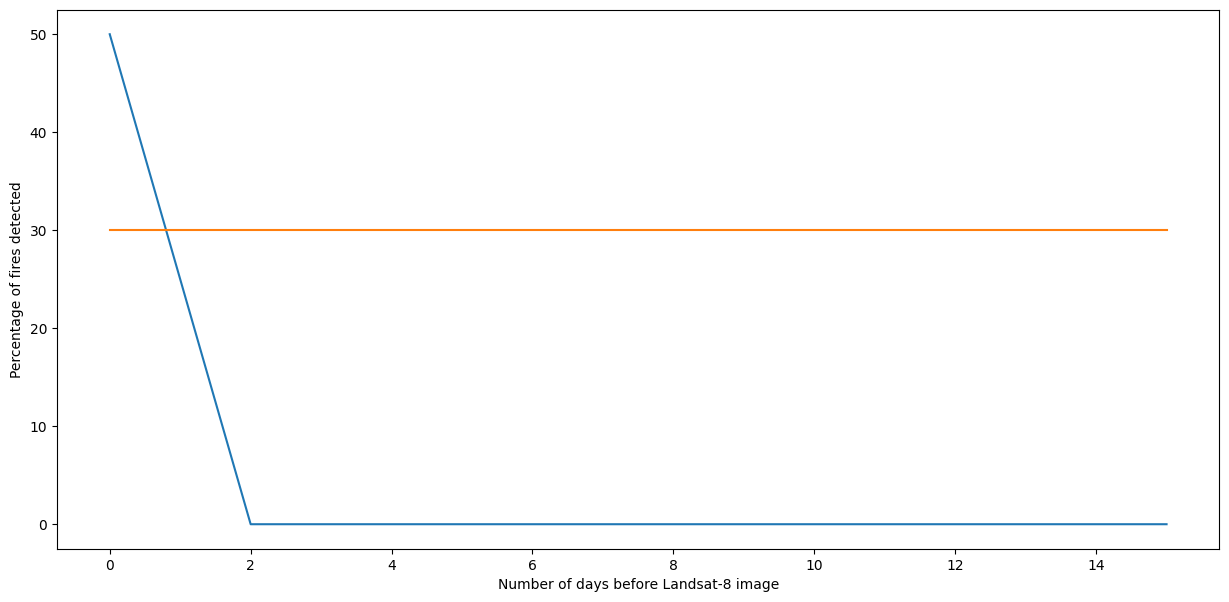

In [ ]:
import matplotlib.pyplot as plt

x_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y_values1 = [50, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_values2 = [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]

# Create the first line chart
plt.plot(x_values, y_values1, label='Landsat')

# Create the second line chart
plt.plot(x_values, y_values2, label='VIIRS')

plt.ylabel("Percentage of fires detected")
plt.xlabel("Number of days before Landsat-8 image")

plt.show()

# VIIRS and MODIS Fire Masks

## Testing fire masks

In [ ]:
image = ee.Image("MODIS/061/MOD09GA/2021_02_02")
display(image)

In [ ]:
image = ee.Image("NOAA/VIIRS/001/VNP14A1/2024_04_09")
display(image)

In [ ]:
image = ee.Image("NOAA/VIIRS/001/VNP14A1/2021_02_02").clip(aoi.geometry().buffer(5000))

palette = [
    'gray',       # 0: not processed (missing input data)
    'gray',       # 1: not processed (obsolete; not used since Collection 1)
    'gray',       # 2: not processed (other reason)
    'blue',       # 3: non-fire water pixel
    'white',      # 4: cloud (land or water)
    'green',      # 5: non-fire land pixel
    'gray',       # 6: unknown (land or water)
    'yellow',     # 7: fire (low confidence, land or water)
    'orange',     # 8: fire (nominal confidence, land or water)
    'red'         # 9: fire (high confidence, land or water)
]
Map = geemap.Map()
Map.addLayerControl()
Map.centerObject(image)
Map.addLayer(aoi, {}, 'aoi')

fire_mask = image.select('FireMask').gte(7)
fire = fire_mask.updateMask(fire_mask)
fire_regions = fire.addBands(fire).reduceToVectors(
        scale = 30,
        reducer = ee.Reducer.mean(),
        maxPixels = 1e10
    )
fire_regions_vis = fire_regions.style(
        color='orange',
        width=4,
        fillColor='orange',  # with alpha set for partial transparency
        # lineType='dotted',
        pointSize=10,
        pointShape='circle',
    )
Map.addLayer(fire_regions_vis, None, 'fire_regions')
fire_regions = fire.addBands(fire).reduceToVectors(
        scale = 1000,
        reducer = ee.Reducer.mean(),
        maxPixels = 1e10
    )

fire_regions_vis = fire_regions.style(
        color='orange',
        width=4,
        fillColor='orange',  # with alpha set for partial transparency
        # lineType='dotted',
        pointSize=10,
        pointShape='circle',
    )
Map.addLayer(fire_regions_vis, None, 'fire_regions_1km')
Map.addLayer(image.select('FireMask').reproject(crs = 'EPSG:32644', crsTransform = [30, 0, 235485, 0, -30, 3312015]), {'min': 0, 'max': 9, 'palette': palette}, 'image')
Map

## Compute and export *fire_regions*

In [ ]:
import sys
sys.setrecursionlimit(10000)

In [ ]:
# Function to get fire regions for aoi from start_date to end_date
def get_fire_regions(aoi, start_date, end_date, method):
    aoi_buffered = aoi.geometry().buffer(2000)

    if method == 'VIIRS':
        imageCollection = ee.ImageCollection("NOAA/VIIRS/001/VNP14A1")\
            .filterDate(start_date, end_date)\
            .filterBounds(aoi_buffered)
    if method == 'MODIS':
        imageCollection = ee.ImageCollection("MODIS/061/MOD14A1")\
            .filterDate(start_date, end_date)\
            .filterBounds(aoi_buffered)

    n = imageCollection.size().getInfo()
    imageList = imageCollection.toList(n)
    fire_regions = ee.FeatureCollection([])
    for i in range(n):
        image = (ee.Image(imageList.get(i))).select('FireMask').rename(['F']).clip(aoi_buffered)
        fire_mask = image.select('F').gte(7)
        fire = fire_mask.updateMask(fire_mask)
        fire_vectors = fire.addBands(fire).reduceToVectors(
            scale = 30,
            geometry = aoi_buffered,
            reducer = ee.Reducer.mean(),
            maxPixels = 1e10
        )
        fire_vectors = fire_vectors.select([]).map(lambda feature: feature.set({'date': image.date().format('YYYY-MM-dd'),'area': feature.area(maxError=1)}))
        fire_regions = fire_regions.merge(fire_vectors)
        # fire_regions = fire_regions.distinct(['date', 'area', '.geo'])

    return fire_regions

In [ ]:
# Input block_name, start_date and end_date
# block_name = 'masalia'
start_date = '2015-07-01'
end_date = '2023-07-01'

# Input method to generate fire regions
method = 'VIIRS'

In [ ]:
#===============================================================================
# Compute fire_regions and export as asset
#===============================================================================


aoi, roi, mws = set_block(block_name)

loopStart = datetime.strptime(start_date,"%Y-%m-%d")
loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
while loopStart < loopEnd:
    curr_start_date = loopStart.strftime("%Y-%m-%d")
    curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")

    print("\nComputing fire regions from", curr_start_date, "to", curr_end_date,"\n")
    loopStart = loopStart+relativedelta(years=1)
    fire_regions = get_fire_regions(aoi, curr_start_date, loopStart.strftime("%Y-%m-%d"), method)
    fire_regions = set_properties(fire_regions, mws)

    output_filename = block_name + '_' + curr_start_date + '_' + curr_end_date
    output_assetid = 'projects/ee-anaad/assets/'+ method +'_fire_regions/'+output_filename
    export_to_asset(fire_regions, output_assetid, output_filename)

## Analysis

In [ ]:
# Input block_name, start_date and end_date
block_name = 'angul'
start_date = '2015-07-01'
end_date = '2023-07-01'

# Input method to generate fire regions
# method = 'VIIRS'
method = 'RFReprojected'

In [ ]:
#===============================================================================
# Display FSI fire points/Landsat fire regions and predicted fire regions on map
#===============================================================================

aoi, roi, _ = set_block(block_name)
# Map to display fire_regions (centroids) and fsi_fires (points buffered by 500 m)
Map = geemap.Map()
Map.addLayerControl()
Map.centerObject(aoi)
Map.addLayer(aoi, None, 'aoi')
Map.addLayer(roi, None, 'roi')
Map

print("Displaying fire regions for", block_name)
aoi, roi, _ = set_block(block_name)
loopStart = datetime.strptime(start_date,"%Y-%m-%d")
loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
while loopStart < loopEnd:
    curr_start_date = loopStart.strftime("%Y-%m-%d")
    curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")

    print("\nMapping fire regions from", curr_start_date, "to", curr_end_date,"\n")

    fsi_fires_id = 'projects/ee-anaad/assets/VIIRS_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
    try:
        ee.data.getAsset(fsi_fires_id)
        fsi_fires = ee.FeatureCollection(fsi_fires_id)
    except ee.EEException:
        fsi_fires = ee.FeatureCollection([])
    num_fsi_fires = fsi_fires.size().getInfo()
    fsi_fires_list = fsi_fires.toList(num_fsi_fires)
    Map.addLayer(fsi_fires.map(lambda feature: feature), {'color': 'yellow'}, 'fsi_fires'+'_'+curr_start_date+'_'+curr_end_date)

    fire_regions_id = 'projects/ee-anaad/assets/'+method+'_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
    try:
        ee.data.getAsset(fire_regions_id)
        fire_regions = ee.FeatureCollection(fire_regions_id)
    except ee.EEException:
        fire_regions = ee.FeatureCollection([])
    num_fire_regions = fire_regions.size().getInfo()
    fire_regions_list = fire_regions.toList(num_fire_regions)
    # Map.addLayer(fire_regions.map(lambda feature: feature.centroid(1).buffer(500)), {'color': 'orange'}, 'fire_regions'+'_'+curr_start_date+'_'+curr_end_date)
    fire_regions_vis = fire_regions.style(
        color='orange',
        width=4,
        fillColor='orange',  # with alpha set for partial transparency
        # lineType='dotted',
        pointSize=10,
        pointShape='circle',
    )
    Map.addLayer(fire_regions_vis, None, 'fire_regions'+'_'+curr_start_date+'_'+curr_end_date)

    loopStart = loopStart+relativedelta(years=1)

Map

### Table

In [ ]:
# Input block_name, start_date and end_date
# block_name = 'masalia'
start_date = '2015-07-01'
end_date = '2023-07-01'

# Input method to generate fire regions
method = 'VIIRS'

In [ ]:
#===============================================================================
# Get comparative statstics
#===============================================================================


time_delta_prev = 1
time_delta_ahead = 1

for block_name in ['angul', 'masalia']:#, 'pindwara', 'mandalgarh']:
    print("\n\nAnalysis for block", block_name)
    aoi, roi, _ = set_block(block_name)
    loopStart = datetime.strptime(start_date,"%Y-%m-%d")
    loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
    while loopStart < loopEnd:
        curr_start_date = loopStart.strftime("%Y-%m-%d")
        curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")

        print("\nComparing fire regions from", curr_start_date, "to", curr_end_date,"\n")

        fsi_fires_id = 'projects/ee-anaad/assets/FSI_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
        try:
            ee.data.getAsset(fsi_fires_id)
            fsi_fires = ee.FeatureCollection(fsi_fires_id)
        except ee.EEException:
            fsi_fires = ee.FeatureCollection([])
        num_fsi_fires = fsi_fires.size().getInfo()
        fsi_fires_list = fsi_fires.toList(num_fsi_fires)

        fire_regions_id = 'projects/ee-anaad/assets/'+method+'_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
        try:
            ee.data.getAsset(fire_regions_id)
            fire_regions = ee.FeatureCollection(fire_regions_id)
        except ee.EEException:
            fire_regions = ee.FeatureCollection([])
        num_fire_regions = fire_regions.size().getInfo()
        fire_regions_list = fire_regions.toList(num_fire_regions)

        num_250 = 0
        num_500 = 0
        num_1000 = 0
        dist_points = {}
        print("Distances of predicted fire regions from FSI fires:")
        for i in range(num_fire_regions):
            fire_region = ee.Feature(fire_regions_list.get(i))
            date = fire_region.get('date').getInfo()
            date = datetime.strptime(date,"%Y-%m-%d")
            min_dist = 1000000
            for j in range (num_fsi_fires):
                fsi_fire = ee.Feature(fsi_fires_list.get(j))
                date_diff = (date-datetime.strptime(fsi_fire.get('date').getInfo(), '%Y-%m-%d')).days
                if date_diff>time_delta_prev or date_diff<-time_delta_ahead:
                    continue
                id = fsi_fire.get('ID').getInfo()
                if id not in dist_points:
                    dist_points[id] = 100000
                distance = fire_region.centroid(1).distance(right=fsi_fire).getInfo()#, maxError=0.001, proj='EPSG:4326')
                dist_points[id] = min(dist_points[id], distance)
                min_dist = min(min_dist, distance)
            if min_dist<250:
                num_250+=1
            elif min_dist<500:
                num_500+=1
            elif min_dist<1000:
                num_1000+=1
            if (min_dist==1000000):
                print("no FSI fire close to satellite image acq. date")
            else:
                print(min_dist)
            # print('[', end='')
            # print(truncate(centroid.get(0).getInfo(), 5), end='')
            # print(',', truncate(centroid.get(-1).getInfo(), 5), end='')
            # print(']', '(%.2f'%(min_dist), end='')
            # print(')')

        print('\nNumber of FSI website fires in given year:', num_fsi_fires)
        print('Number of fire regions predicted:', num_fire_regions)
        print('Number of predicted fires within 250 m radius of FSI website fires:', num_250)
        print('Number of predicted fires within 250 - 500 m radius of FSI website fires:', num_500)
        print('Number of predicted fires within 500 - 1000 m radius of FSI website fires:', num_1000)

        num_250 = 0
        num_500 = 0
        num_1000 = 0
        for key in dist_points:
            distance = dist_points[key]
            # print(distance)
            if distance<250:
                num_250+=1
            elif distance<500:
                num_500+=1
            elif distance<1000:
                num_1000+=1

        print('\nNumber of FSI website fires considered:', len(dist_points))
        print('Number of FSI website fires within 250 m radius of predicted fires:', num_250)
        print('Number of FSI website fires within 250 - 500 m radius of predicted fires:', num_500)
        print('Number of FSI website fires within 500 - 1000 m radius of predicted fires:', num_1000)

        loopStart = loopStart+relativedelta(years=1)

### Graph

In [ ]:
angul_dates = ['2020-07-09', '2021-07-12', '2022-07-15']
masalia_dates = ['2020-07-02', '2021-07-05', '2022-07-08']

In [ ]:
# Input block_name, start_date and end_date
block_name = 'masalia'
image_dates = masalia_dates
start_date = '2020-07-01'
end_date = '2023-07-01'

# Input method to generate fire regions
method = 'VIIRS'

In [ ]:
#===============================================================================
# Get comparative statstics also
#===============================================================================

# time_delta_prev = 15
# time_delta_ahead = 0

# for block_name in ['angul', 'masalia']:#, 'pindwara', 'mandalgarh']:
print("\n\nAnalysis for block", block_name, "using", method, "\n")
aoi, roi, _ = set_block(block_name)
loopStart = datetime.strptime(start_date,"%Y-%m-%d")
loopEnd = datetime.strptime(end_date,"%Y-%m-%d")
ind = 0
while loopStart < loopEnd:
    curr_start_date = loopStart.strftime("%Y-%m-%d")
    curr_end_date = (loopStart+relativedelta(years=1)-timedelta(days=1)).strftime("%Y-%m-%d")
    print(curr_start_date, "to", curr_end_date,"\n")

    fsi_fires_id = 'projects/ee-anaad/assets/FSI_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
    try:
        ee.data.getAsset(fsi_fires_id)
        fsi_fires = ee.FeatureCollection(fsi_fires_id)
    except ee.EEException:
        fsi_fires = ee.FeatureCollection([])
    num_fsi_fires = fsi_fires.size().getInfo()
    fsi_fires_list = fsi_fires.toList(num_fsi_fires)

    fire_regions_id = 'projects/ee-anaad/assets/'+method+'_fire_regions/'+ block_name +'_'+ curr_start_date + '_' + curr_end_date
    try:
        ee.data.getAsset(fire_regions_id)
        fire_regions = ee.FeatureCollection(fire_regions_id)
    except ee.EEException:
        fire_regions = ee.FeatureCollection([])
    num_fire_regions = fire_regions.size().getInfo()
    fire_regions_list = fire_regions.toList(num_fire_regions)

    print("num_fsi_fires", num_fsi_fires)
    print("num_fire_regions", num_fire_regions)


    fires = [0 for _ in range(16)]
    detections = [0 for _ in range(16)]
    regions = [0 for _ in range(23)]
    fires_dict = {}
    # regions_dict = {}
    image_date = image_dates[ind]
    for k in range(23):
        for j in range (num_fsi_fires):
            fsi_fire = ee.Feature(fsi_fires_list.get(j))
            date = fsi_fire.get('date').getInfo()
            date_diff = (datetime.strptime(image_date, '%Y-%m-%d')-datetime.strptime(date, '%Y-%m-%d')).days
            if date_diff>15 or date_diff<0:
                    continue
            id = fsi_fire.get('ID').getInfo()
            if id not in fires_dict:
                fires_dict[id] = 0
                fires[date_diff]+=1
            if fires_dict[id]==1:
                continue
            for i in range(num_fire_regions):
                fire_region = ee.Feature(fire_regions_list.get(i))
                if date_diff!=(datetime.strptime(image_date, '%Y-%m-%d')-datetime.strptime(fire_region.get('date').getInfo(), '%Y-%m-%d')).days:
                    continue
                # region_id = fire_region.get('ID').getInfo()
                # if region_id not in regions_dict:
                #     regions_dict[region_id] = 1
                #     regions[k]+=1
                if fires_dict[id]==0:
                    distance = fire_region.centroid(1).distance(right=fsi_fire).getInfo()#, maxError=0.001, proj='EPSG:4326')
                    if distance<1000:
                        fires_dict[id] = 1
                        detections[date_diff]+=1
        image_date = datetime.strptime(image_date,"%Y-%m-%d")
        image_date = (image_date+relativedelta(days=16)).strftime("%Y-%m-%d")

    print(fires)
    print(detections)
    print()

    ind+=1
    loopStart = loopStart+relativedelta(years=1)

In [ ]:
# Angul
[7, 2, 1, 3, 2, 5, 12, 3, 0, 0, 3, 1, 11, 4, 9, 1]
[4, 0, 0, 0, 0, 0, 12, 0, 0, 0, 2, 0, 7, 0, 0, 0]
# Masalia
[1, 10, 13, 9, 0, 3, 2, 2, 23, 4, 2, 1, 9, 26, 24, 4]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 10, 0]

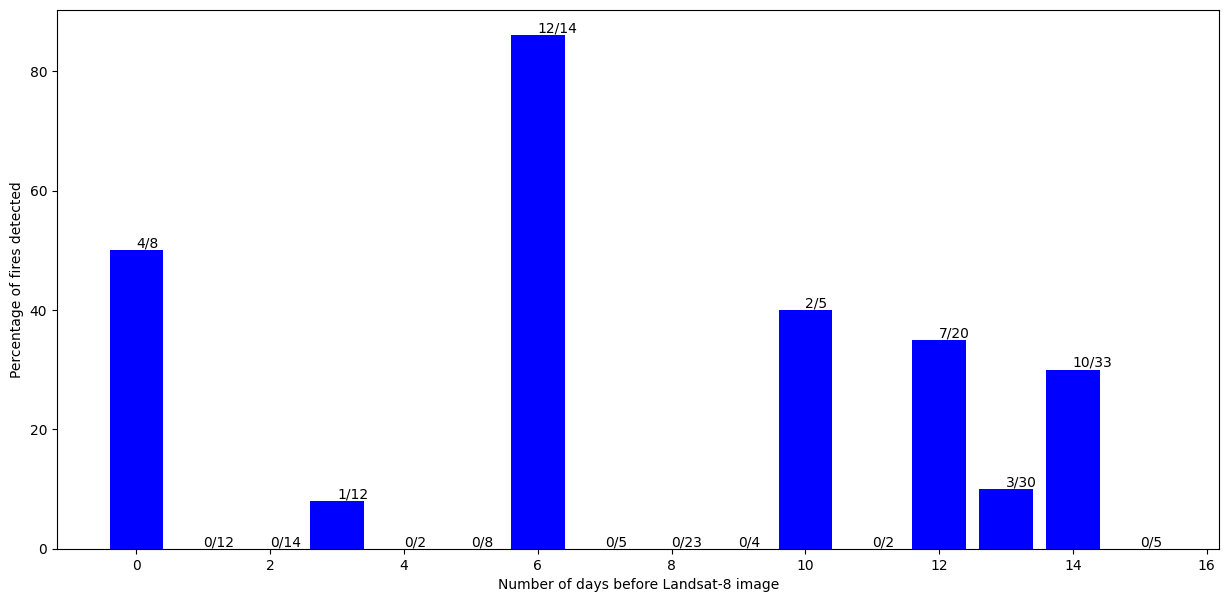

In [ ]:
#===============================================================================
# Plot statistics
#===============================================================================

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (15,7)

# Angul
denom1 = [7, 2, 1, 3, 2, 5, 12, 3, 0, 0, 3, 1, 11, 4, 9, 1]
numer1 = [4, 0, 0, 0, 0, 0, 12, 0, 0, 0, 2, 0, 7, 0, 0, 0]
# Masalia
denom2 = [1, 10, 13, 9, 0, 3, 2, 2, 23, 4, 2, 1, 9, 26, 24, 4]
numer2 = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 10, 0]

xcoord = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
color = 'blue'
ycoord = [50, 0, 0, 8, 0, 0, 86, 0, 0, 0, 40, 0, 35, 10, 30, 0]
# for i in range(16):
    # ycoord = int(100.0*(numer1[i]+numer2[i])/(denom1[i]+denom2[i]))

# for ind in range(16):
    # color = colors[ind]
    # plt.scatter(xcoord[ind], ycoord[ind], color=color)
plt.bar(xcoord, ycoord, color=color)


# [plt.text(i, j, j) for (i, j) in zip(xcoord, ycoord)]
for i in range(16):
    plt.text(xcoord[i], ycoord[i], str(numer1[i]+numer2[i])+'/'+str(denom1[i]+denom2[i]), fontsize=10, ha='left', va='bottom')


plt.ylabel("Percentage of fires detected")
# plt.xticks(rotation=30)
plt.xlabel("Number of days before Landsat-8 image")

plt.show()

# [Forecasting Forest Fire Danger Conditions at a Four-Day Scale](https://www.mdpi.com/2072-4292/11/18/2101)

In [ ]:
image = ee.Image("MODIS/061/MOD09GA/2021_02_02")
display(image)

In [ ]:
image = ee.Image("MODIS/061/MOD11A1/2021_02_02")
display(image)

In [ ]:
image = ee.ImageCollection("MODIS/061/MCD12Q1").first()
display(image)

In [ ]:
ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('ndvi')
ndwi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b07']).rename('ndwi')

In [ ]:
ndvi

In [ ]:
gaul_level2 = ee.FeatureCollection("FAO/GAUL/2015/level2")
alberta_boundary = gaul_level2.filter(ee.Filter.eq('ADM1_NAME', 'Alberta'))

mcd12q1 = ee.Image('MODIS/006/MCD12Q1/2015_01_01')
# https://lpdaac.usgs.gov/documents/1409/MCD12_User_Guide_V61.pdf

# Define the legend for Leaf Area Index (LAI)
legend = {
    0: 'Water Bodies',
    1: 'Grasslands',
    2: 'Shrublands',
    3: 'Broadleaf Croplands',
    4: 'Savannas',
    5: 'Evergreen Broadleaf Forests',
    6: 'Deciduous Broadleaf Forests',
    7: 'Evergreen Needleleaf Forests',
    8: 'Deciduous Needleleaf Forests',
    9: 'Unvegetated',
    10: 'Urban and Built-up Lands',
    255: 'Unclassified'
}

# Define the colors for visualization
colors = ['0000FF', '00FF00', '32CD32', 'FFFF00', 'CD853F', '008000',
          '228B22', '006400', '2E8B57', '000000', 'FF0000', 'FFFFFF']

# Clip the MCD12Q1 dataset to Alberta boundary
mcd12q1_alberta = mcd12q1.clip(alberta_boundary)

# Select the Land Cover Type 3 (LC Type3) band representing LAI
lai = mcd12q1_alberta.select('LC_Type3')

# Apply a color palette to the LAI band
lai_vis = lai.visualize(min=0, max=10, palette=colors)

# Add the LAI layer to the map
Map = geemap.Map(center=[53.7267, -127.6476], zoom=6)
Map.addLayer(lai_vis, {}, 'Leaf Area Index (LAI)')
Map.add_legend(legend_title="Leaf Area Index (LAI)", legend_keys=list(legend.keys()), legend_values=list(legend.values()), layer_name='Leaf Area Index (LAI)')
Map.addLayer(alberta_boundary, {}, 'Alberta Boundary')
Map.addLayerControl()
Map

In [ ]:
date = '2020-07-01'
date_ee = ee.Date(date)
year = date_ee.get('year').getInfo()
start_date = ee.Date.fromYMD(year, 1, 1)
end_date = ee.Date.fromYMD(year + 1, 1, 1)
print(start_date.getInfo())
print(end_date)

In [ ]:
date = '2021-02-02'
date_ee = ee.Date(date)
image = ee.Image("MODIS/061/MOD09GA/2021_02_02")
display(image)
modis_collection = ee.ImageCollection("MODIS/061/MOD09GA") \
        .filterDate('2021-01-01', '2022-01-01')
prev_images = modis_collection.filterDate(date_ee.advance(-4, 'day'), date_ee)
prev_images.select('sur_refl_b01')

In [ ]:
def forecast(aoi, date):
    def calculate_indices(image):
        ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('ndvi')
        ndwi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b07']).rename('ndwi')
        return ndvi.addBands(ndwi)

    date_ee = ee.Date(date)
    year = date_ee.get('year').getInfo()
    start_date = f'{year}-01-01'
    end_date = f'{year + 1}-01-01'


    modis_collection = ee.ImageCollection("MODIS/061/MOD09GA") \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date)
    projection = modis_collection.first().select('sur_refl_b01').projection().getInfo()

    indices_collection = modis_collection.map(calculate_indices)
    # display(indices_collection)
    mean_ndvi = indices_collection.select('ndvi').mean().reproject(crs = projection['crs'], crsTransform = projection['transform'])
    mean_ndwi = indices_collection.select('ndwi').mean().reproject(crs = projection['crs'], crsTransform = projection['transform'])

    prev_images = modis_collection.filterDate(date_ee.advance(-4, 'day'), date_ee)
    prev_images_with_indices = prev_images.map(calculate_indices)
    max_ndvi = prev_images_with_indices.select('ndvi').max().reproject(crs = projection['crs'], crsTransform = projection['transform'])
    max_ndwi = prev_images_with_indices.select('ndwi').max().reproject(crs = projection['crs'], crsTransform = projection['transform'])


    temp_collection = ee.ImageCollection("MODIS/061/MOD11A1") \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date)

    mean_temp = temp_collection.select('LST_Day_1km').mean()
    mean_temp = mean_temp.select('LST_Day_1km').reproject(crs = projection['crs'], crsTransform = projection['transform'])

    prev_images_with_temp = temp_collection.filterDate(date_ee.advance(-4, 'day'), date_ee).select('LST_Day_1km').mean()
    prev_images_with_temp = prev_images_with_temp.select('LST_Day_1km').reproject(crs = projection['crs'], crsTransform = projection['transform'])


    ret = max_ndvi.select('ndvi').gte(mean_ndvi.select('ndvi'))
    ret = ret.add(max_ndwi.select('ndwi').gte(mean_ndwi.select('ndwi')))
    ret = ret.add(prev_images_with_temp.select('LST_Day_1km').gte(mean_temp.select('LST_Day_1km')))
    return ret.rename('danger')

In [ ]:
aoi=aoi_angul
date = '2020-07-01'
image = forecast(aoi, date)
Map = geemap.Map()
Map.addLayerControl()
Map.centerObject(aoi)
Map.addLayer(aoi)
# Map.addLayer(image.select('danger').clip(aoi), {'min': 0, 'max': 3, 'palette': ['green', 'yellow', 'orange', 'red']}, 'img')

legend = {
    0: 'Low',
    1: 'Moderate',
    2: 'High',
    3: 'Very High',
}
colors = ['green', 'yellow', 'orange', 'red']

lai = image.clip(aoi).select('danger')
lai_vis = lai.visualize(min=0, max=3, palette=colors)
Map.addLayer(lai_vis, {}, 'Danger')
Map

# Time Series Analysis

In [ ]:
# Run the code below to visualize AEZ boundaries
Map = geemap.Map()
Map.addLayerControl()

Map.addLayer(aez_boundaries, {}, 'AEZs')
Map.addLayer(block_boundaries, {}, 'Blocks')

n = aez_boundaries.size().getInfo()
aez_list = aez_boundaries.toList(n)
for i in range(n):
    aez = ee.Feature(aez_list.get(i))
    Map.addLayer(aez, {}, 'aez'+str(aez.get('ae_regcode').getInfo()))

Map

## Helper Functions

In [ ]:
bands_to_select = ['Tair_f_inst', 'Evap_tavg', 'Qair_f_inst', 'Rainf_f_tavg', 'SoilTMP0_10cm_inst', 'Wind_f_inst']
bands_add = ['Evap_tavg', 'Rainf_f_tavg']
bands_avg = ['Tair_f_inst', 'Qair_f_inst', 'SoilTMP0_10cm_inst', 'Wind_f_inst']

def get_data_row(aoi_geo, landsatImagePrefix, date_object, method):
    dict_row = {}

    getFireMask = None
    if method == 'Murphy':
        getFireMask = getFireMaskMurphy
    elif method=='Schroder':
        getFireMask = getFireMaskSchroeder
    elif method=='OldRandomForest':
        getFireMask = getFireMaskOldRandomForest
    elif method=='RFLandsat':
        getFireMask = getFireMaskRFLandsat
    elif method=='RFNativeProjections':
        getFireMask = getFireMaskRFNativeProjections
    elif method=='RFReprojected':
        getFireMask = getFireMaskRFReprojected

    landsatImageId = landsatImagePrefix+date_object.strftime("%Y%m%d")
    try:
        ee.data.getAsset(landsatImageId)
    except ee.EEException:
        print(landsatImageId, 'does not exist.')
        return None
    image = ee.Image(landsatImageId).clip(aoi_geo)
    fire_mask = getFireMask(image)#.updateMask(forest_mask)
    fire = fire_mask.updateMask(fire_mask)
    fire_pixels = fire.reduceRegion(reducer = ee.Reducer.sum(), scale = 30, maxPixels = 1e8)
    num_fires = ee.Number(fire_pixels.get('F')).getInfo()
    # fire_vectors = fire.addBands(fire).reduceToVectors(
    #     geometry = aoi_buffered,
    #     scale = 30,
    #     reducer = ee.Reducer.mean(),
    #     maxPixels = 1e10
    # )
    # num_fires = fire_vectors.size().getInfo()
    dict_row['Num_fires'] = num_fires

    def get_climatic_data(ind):
        start_date = (date_object+timedelta(days=ind)).strftime("%Y-%m-%d")
        end_date = (date_object+timedelta(days=ind+1)).strftime("%Y-%m-%d")
        ic = ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H")\
        .filterBounds(aoi_geo)\
        .filterDate(start_date, end_date)

        image1 = ic.select(bands_avg).mean().clip(aoi_geo)
        mean_values = image1.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_geo)
        values = mean_values.getInfo()
        for key in values:
            dict_row[key+str(ind)] = values[key]

        image2 = ic.select(bands_add).sum().clip(aoi_geo)
        mean_values = image2.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_geo)
        values = mean_values.getInfo()
        for key in values:
            dict_row[key+str(ind)] = values[key]*86400

    for ind in range(3):
        get_climatic_data(ind)

    return dict_row

In [ ]:
def get_data_matrix(aoi, start_date, end_date, method):
    dict_rows = []
    aoi_geo = aoi.geometry()

    landsatImageCollection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")\
        .filterBounds(aoi_geo)\
        .filterDate(start_date, (datetime.strptime(start_date, "%Y-%m-%d")+timedelta(days=16)).strftime("%Y-%m-%d"))
    while(landsatImageCollection.size().getInfo() == 0):
        start_date = (datetime.strptime(start_date, "%Y-%m-%d")+timedelta(days=16)).strftime("%Y-%m-%d")
        landsatImageCollection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")\
        .filterBounds(aoi_geo)\
        .filterDate(start_date, (datetime.strptime(start_date, "%Y-%m-%d")+timedelta(days=16)).strftime("%Y-%m-%d"))

    n = landsatImageCollection.size().getInfo()
    landsatImageList = ee.List(landsatImageCollection.toList(n))
    max_intersection_area = 0
    landsatImageId = None
    for i in range(n):
        landsatImage = ee.Image(landsatImageList.get(i))
        intersection_area = landsatImage.geometry().intersection(aoi_geo).area().getInfo()
        if intersection_area > max_intersection_area:
            max_intersection_area = intersection_area
            landsatImageId = landsatImage.id().getInfo()
    date_string = landsatImageId[-8:]
    date_object = datetime.strptime(date_string, "%Y%m%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    landsatImagePrefix = 'LANDSAT/LC08/C02/T1_TOA/'+landsatImageId[:11]+'_'

    adi = aoi.get('ADI 2019').getInfo()
    while date_object < end_date:
        dict_row = get_data_row(aoi_geo, landsatImagePrefix, date_object, method)
        if dict_row != None:
            dict_row['ADI'] = adi
            dict_rows.append(dict_row)
        date_object = date_object+timedelta(days=16)

    return pd.DataFrame(dict_rows)

## Testing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm
from scipy.stats import zscore

In [ ]:
blocks = block_boundaries.filter(ee.Filter.eq('aez_id', 12))

sampled_blocks = blocks.randomColumn()
sampled_blocks = sampled_blocks.filter('random < 0.03')
display(sampled_blocks)

In [ ]:
start_date = '2019-07-01'
end_date = '2022-07-01'
Map = geemap.Map()
Map.addLayerControl()
Map

In [ ]:
data = pd.DataFrame()

b = sampled_blocks.size().getInfo()
print(b)
blocks_list = sampled_blocks.toList(b)
for i in range(b):
    block = ee.Feature(blocks_list.get(i))
    print(block.get('Subdistric').getInfo())
    Map.addLayer(block, {}, 'block'+str(i))
    print('Generating data for block ....')
    block_data = get_data_matrix(block, '2019-07-01', '2022-07-01', 'OldRandomForest')
    print('done')
    data = pd.concat([data, block_data], ignore_index=True)

In [ ]:
positive_data = data[data['Num_fires'] > 0]
zero_data = data[data['Num_fires'] == 0]
zero_data = zero_data.sample(n = len(positive_data)).reset_index(drop=True)
balanced_data = pd.concat([positive_data, zero_data], ignore_index=True, sort=False)
balanced_data_z = balanced_data.apply(zscore)